---
title: "Demonstration of the Package created"
author: "Jorge Bris Moreno"
format:
  html:
    embed-resources: true
    code-fold: true
    toc: true
---

# General Information

In [1]:
from Tabula import BoatEnv, GridWorldEnv, GeosearchEnv, MCSolver, TDSolver, PolicyPlotter_DP, PolicyPlotter_MC_TD, DPSolver
import matplotlib.pyplot as plt
import numpy as np

**Note**: This is a demonstration of the package created. The package is called 'Tabula' and it also prints which episode it is on in order to keep track of your progress (a common practice). Only one solver of each method (DP, MC, TD) is shown for each environment for the sake of brevity, but all of them have been used in this demonstration (just for different games).

**Additional note on Geosearch**: Due to the large environment, while the optimal policy is being reported, for some other reported mechanisms we are only reporting a few samples.

## Games

This package contains three games: Boat, Gridworld and Geosearch.

### Boat:

This environment consists of a Boat that has to move left or right and the wind can also push it to the left or right. The goal is to maximize the rewards as shown in the picture below.

![](images/2024-10-13-14-28-20.png)

### Gridworld:

This environment consists of a Gridworld with a start and a goal. The goal is to reach the goal / maximum reward as shown in the picture below. The environment is noisy and the agent can move in four directions: up, down, left and right. However, sometimes the agent can move in a different direction than the one chosen due to the noise.

![](images/2024-10-13-14-30-54.png)

### Geosearch:

The goal of this environment is to reach the resources and maximize the reward. While the two resources utilized are desired, one of them is more valuable than the other. The both have different probability distributions and size. The grid is 25 by 25 and the agent can move in four directions: up, down, left and right. The image below shows the intent of the environment (even though this is a simpler approximation).

![](images/2024-10-13-15-41-00.png)

## Information about the package

Each game can be rendered by running the following commented code in order to visualize the game. It can also be put in the hyperparameters of the game to render the game automatically. The default is render = False.

The environments are: GeosearchEnv, GridWorldEnv, and BoatEnv. The solvers are: DPSolver, MCSolver, and TDSolver. We also have a function to plot the optimal policy of the environment. They are PolicyPlotter_MC_TD (for MC and TD) and PolicyPlotter_DP (only for DP). The code is docummented and I suggest visiting the code to see the details of the functions.

Below you will see a demonstration of the usage of the package created. DP solver has either value iteration or policy iteration (default is policy iteration). It also initializes its policy with a initial random policy where each transition is equally likely. MC solver has Exploring starts (default set as true) or On-Policy First-Visit Monte Carlo Control. It uses an epsilon greedy policy. Finally, the TD solver has the option for SARSA or Q-learning (default is SARSA). It also uses and epsilon greedy policy.

Due to the differences of the games, even though some reporting has been standarized, others due to the large amount of states, it is not possible to show all the results and different techniques have been used. The results are shown in the code and the code is well documented.

Each environment can be visualized by running the commented code below. The code is commented out to avoid the rendering of the games.

In [2]:
# def visualize_grid_world():
#     # Initialize the environment
#     env = GeosearchEnv(), GridWorldEnv(), BoatEnv()
#     env.reset()
    
#     # Render the initial state
#     env.render()

#     # Keep the window open for a specified amount of time
#     import time
#     time.sleep(25)  # Adjust time as needed

#     # Close the environment
#     env.close()

# if __name__ == "__main__":
#     visualize_grid_world()

# Dynamic Programming

In this section, we will show the results of the Dynamic Programming solver for all the three games on our package. Remember you an utilize either value iteration or policy iteration. The default is policy iteration.

## Boat Solved with DP

We will solve the boat environment using Dynamic Programming with Policy Iteration.

State-Value Function V:
State 0: V = 397.5733
State 1: V = 399.9915

Action-Value Function Q:
Q(0, 0) = 394.5976
Q(0, 1) = 397.5734
Q(1, 0) = 397.9734
Q(1, 1) = 399.9916

Optimal Policy:
State 0: Take action 'East'
State 1: Take action 'East'


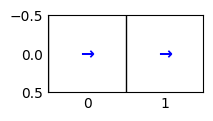

In [ ]:
# Create the environment
env = BoatEnv()

# Do not render the environment
env.rendering_enabled = False

# Solver
solver = DPSolver(env, gamma=0.99, theta=0.0001, use_value_iteration=False)

# Solve
policy, V, Q = solver.solve()

# Print the State-Value Function V
print("State-Value Function V:")
for s in range(solver.state_space_size):
    print(f"State {s}: V = {V[s]:.4f}")

# Print the Action-Value Function Q
print("\nAction-Value Function Q:")
for s in range(solver.state_space_size):
    for a in range(env.action_space.n):
        print(f"Q({s}, {a}) = {Q[s, a]:.4f}")

# Print the Optimal Policy
print("\nOptimal Policy:")
for s in range(solver.state_space_size):
    action = policy[s]
    action_name = "East" if action == 1 else "West"
    print(f"State {s}: Take action '{action_name}'")

boat_action_symbols = {0: '←', 1: '→'}
boat_plotter = PolicyPlotter_DP((1, 2), policy, action_symbols=boat_action_symbols)
boat_plotter.plot()

The results of the policy are as expected. The boat recieves greater rewards on its right side and the policy is to move to the right. It is a very simple environment and the policy is very clear. It also trains very fast.

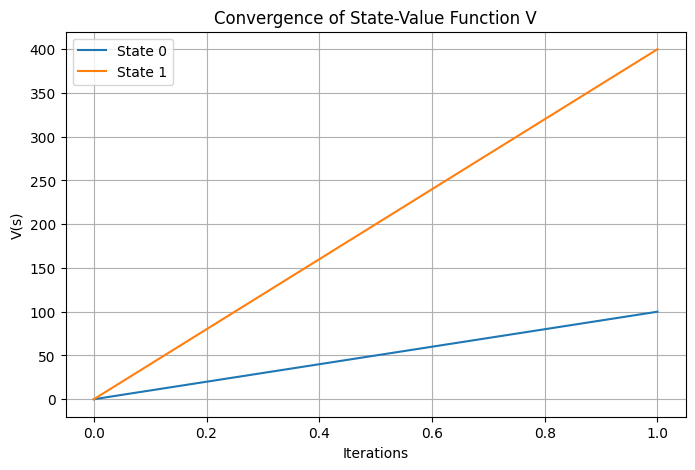

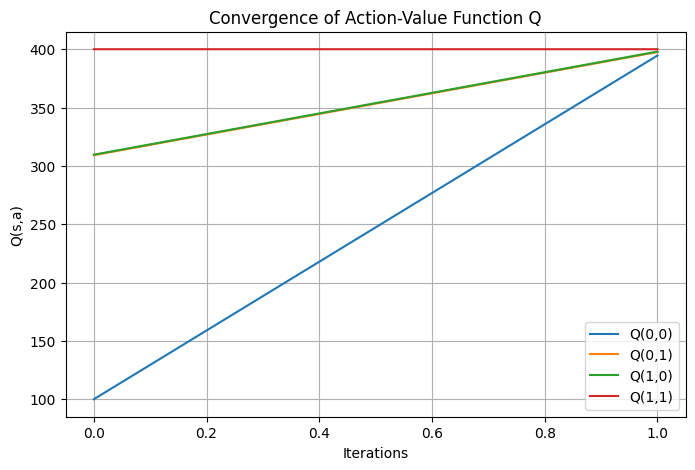

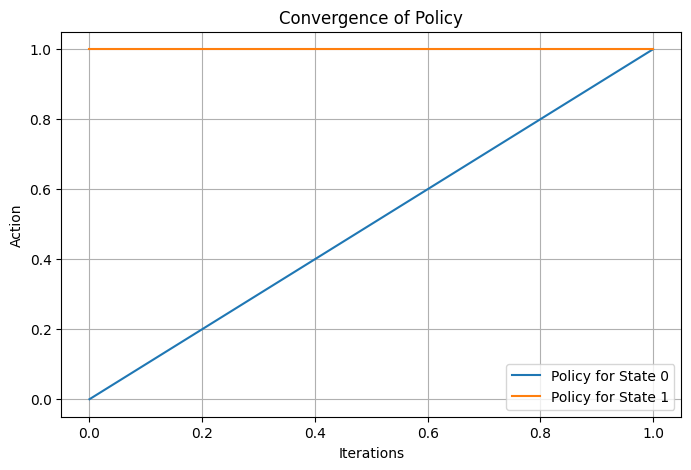

In [3]:
# Plot convergence of V
V_history = np.array(solver.V_history)
plt.figure(figsize=(8, 5))
for s in range(solver.state_space_size):
    plt.plot(V_history[:, s], label=f"State {s}")
plt.xlabel('Iterations')
plt.ylabel('V(s)')
plt.title('Convergence of State-Value Function V')
plt.legend()
plt.grid(True)
plt.show()

# Plot convergence of Q
Q_history = np.array(solver.Q_history)
plt.figure(figsize=(8, 5))
for s in range(solver.state_space_size):
    for a in range(env.action_space.n):
        plt.plot(Q_history[:, s, a], label=f"Q({s},{a})")
plt.xlabel('Iterations')
plt.ylabel('Q(s,a)')
plt.title('Convergence of Action-Value Function Q')
plt.legend()
plt.grid(True)
plt.show()

# Plot convergence of policy
policy_history = np.array(solver.policy_history)
plt.figure(figsize=(8, 5))
for s in range(solver.state_space_size):
    plt.plot(policy_history[:, s], label=f"Policy for State {s}")
plt.xlabel('Iterations')
plt.ylabel('Action')
plt.title('Convergence of Policy')
plt.legend()
plt.grid(True)
plt.show()




Here, we can see that it only needs very few iterations to converge.

## Gridworld Solved with DP

We will solve the gridworld environment using Dynamic Programming with Value Iteration.

State-Value Function V:
[[4536.43946403 4583.27228353 4630.57816083 4678.36187432 4726.62825061
  4775.38216512]
 [4583.27228353 4630.57816083 4678.36187432 4726.62825061 4775.38216512
  4824.62854246]
 [4630.57816083 4678.36187432 4726.62825061 4775.38216512 4824.62854246
  4874.37235704]
 [4583.27237923 4630.57825557 4678.36196811 4824.62854246 4874.37235704
  4924.61863347]
 [4536.43965543 4583.27247302 4824.62854246 4874.37235704 4924.61863347
  4975.37244714]
 [4490.07525888 4536.43974829 4874.37235704 4924.61863347 4975.37244714
  4924.61872266]]

Action-Value Function Q:
State 0:
  Action 0: Q = 4490.0751
  Action 1: Q = 4536.4396
  Action 2: Q = 4536.4396
  Action 3: Q = 4490.0751
State 1:
  Action 0: Q = 4536.4396
  Action 1: Q = 4536.4396
  Action 2: Q = 4583.2724
  Action 3: Q = 4490.0751
State 2:
  Action 0: Q = 4583.2724
  Action 1: Q = 4630.5783
  Action 2: Q = 4583.2724
  Action 3: Q = 4536.4396
State 3:
  Action 0: Q = 4630.5783
  Action 1: Q = 4678.3620
  Action 2: Q =

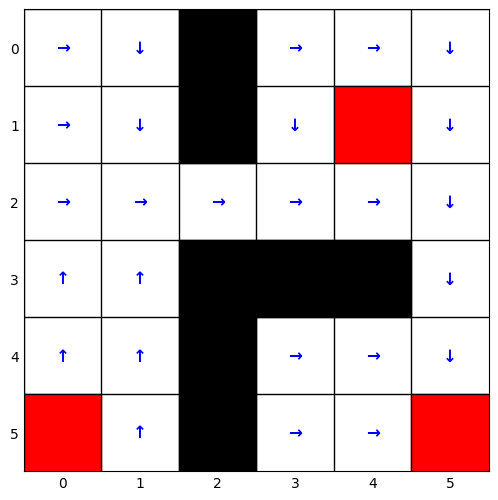

In [ ]:
# Create the environment
env = GridWorldEnv()

# Don't render
env.rendering_enabled = False

# Solver
solver = DPSolver(env, gamma=0.99, theta=0.0001, use_value_iteration=True)

# Solve
policy, V, Q = solver.solve()

# Print the State-Value Function V
print("State-Value Function V:")
V_grid = V.reshape(env.grid_size)
print(V_grid)

# Print the Action-Value Function Q
print("\nAction-Value Function Q:")
for s in range(solver.state_space_size):
    state = solver.index_to_state(s)
    print(f"State {state}:")
    for a in range(env.action_space.n):
        print(f"  Action {a}: Q = {Q[s, a]:.4f}")

# Print the Optimal Policy
print("\nOptimal Policy:")
# Up, Right, Down, Left
action_symbols = ['↑', '→', '↓', '←']
for s in range(solver.state_space_size):
    action = policy[s]
    action_name = action_symbols[action]
    print(f"State {solver.index_to_state(s)}: Take action '{action_name}'")

# Convert terminal states to a list of coordinates for the plotter
terminal_coords = list(env.terminal_states.keys())

# Plot with walls and terminal states
plotter = PolicyPlotter_DP(env.grid_size, policy, walls=list(env.walls), terminal_states=terminal_coords)
plotter.plot()

The results are as expected, trying to reach for the bottom right corner which has the maximum reward. It also trains very fast.

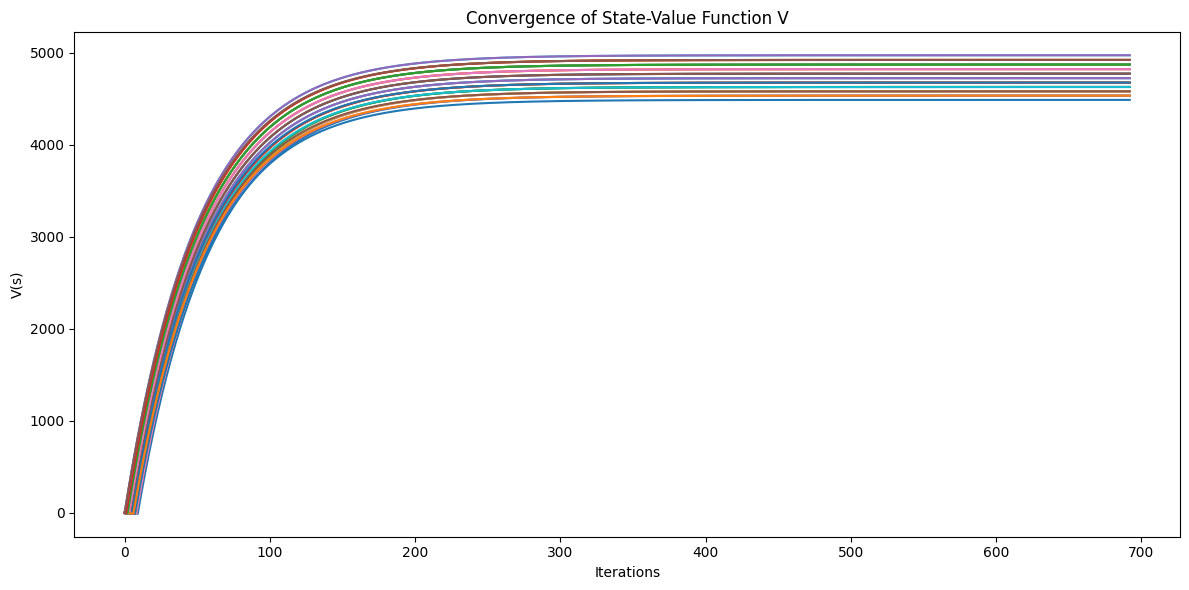

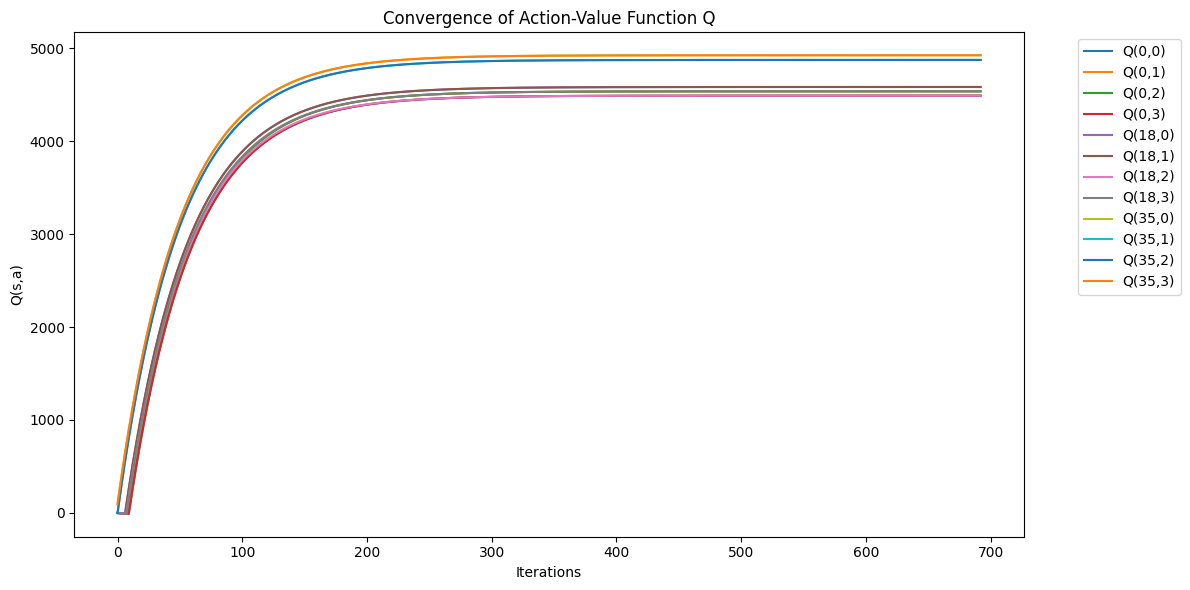

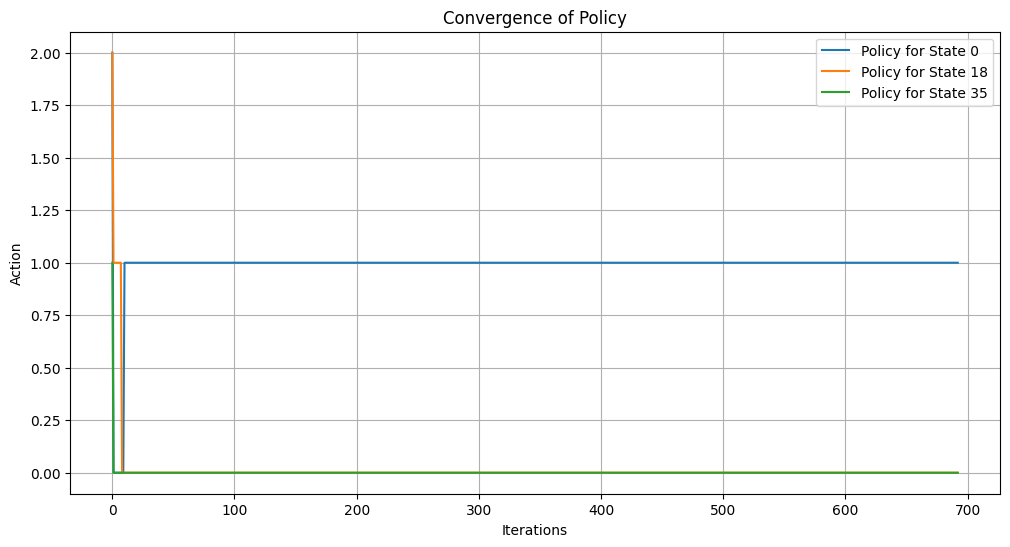

In [ ]:
# Plot convergence of V
V_history = np.array(solver.V_history)
plt.figure(figsize=(12, 6))
for s in range(solver.state_space_size):
    plt.plot(V_history[:, s], label=f"State {s}")
plt.xlabel('Iterations')
plt.ylabel('V(s)')
plt.title('Convergence of State-Value Function V')
plt.tight_layout()
plt.show()

# Plot convergence of Q for a few state-action pairs
Q_history = np.array(solver.Q_history)
plt.figure(figsize=(12, 6))
states_to_plot = [0, env.grid_size[1]*env.grid_size[0]//2, solver.state_space_size - 1]
actions = [0, 1, 2, 3]
for s in states_to_plot:
    for a in actions:
        plt.plot(Q_history[:, s, a], label=f"Q({s},{a})")
plt.xlabel('Iterations')
plt.ylabel('Q(s,a)')
plt.title('Convergence of Action-Value Function Q')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Plot convergence of policy for a few states
policy_history = np.array(solver.policy_history)
plt.figure(figsize=(12, 6))
for s in states_to_plot:
    plt.plot(policy_history[:, s], label=f"Policy for State {s}")
plt.xlabel('Iterations')
plt.ylabel('Action')
plt.title('Convergence of Policy')
plt.legend()
plt.grid(True)
plt.show()


Based on this plots, even though this environment is more complex than the other and has noise, it converges very fast.

## Gesearch solved with DP

We will solve the geosearch environment using Dynamic Programming with Value Iteration.

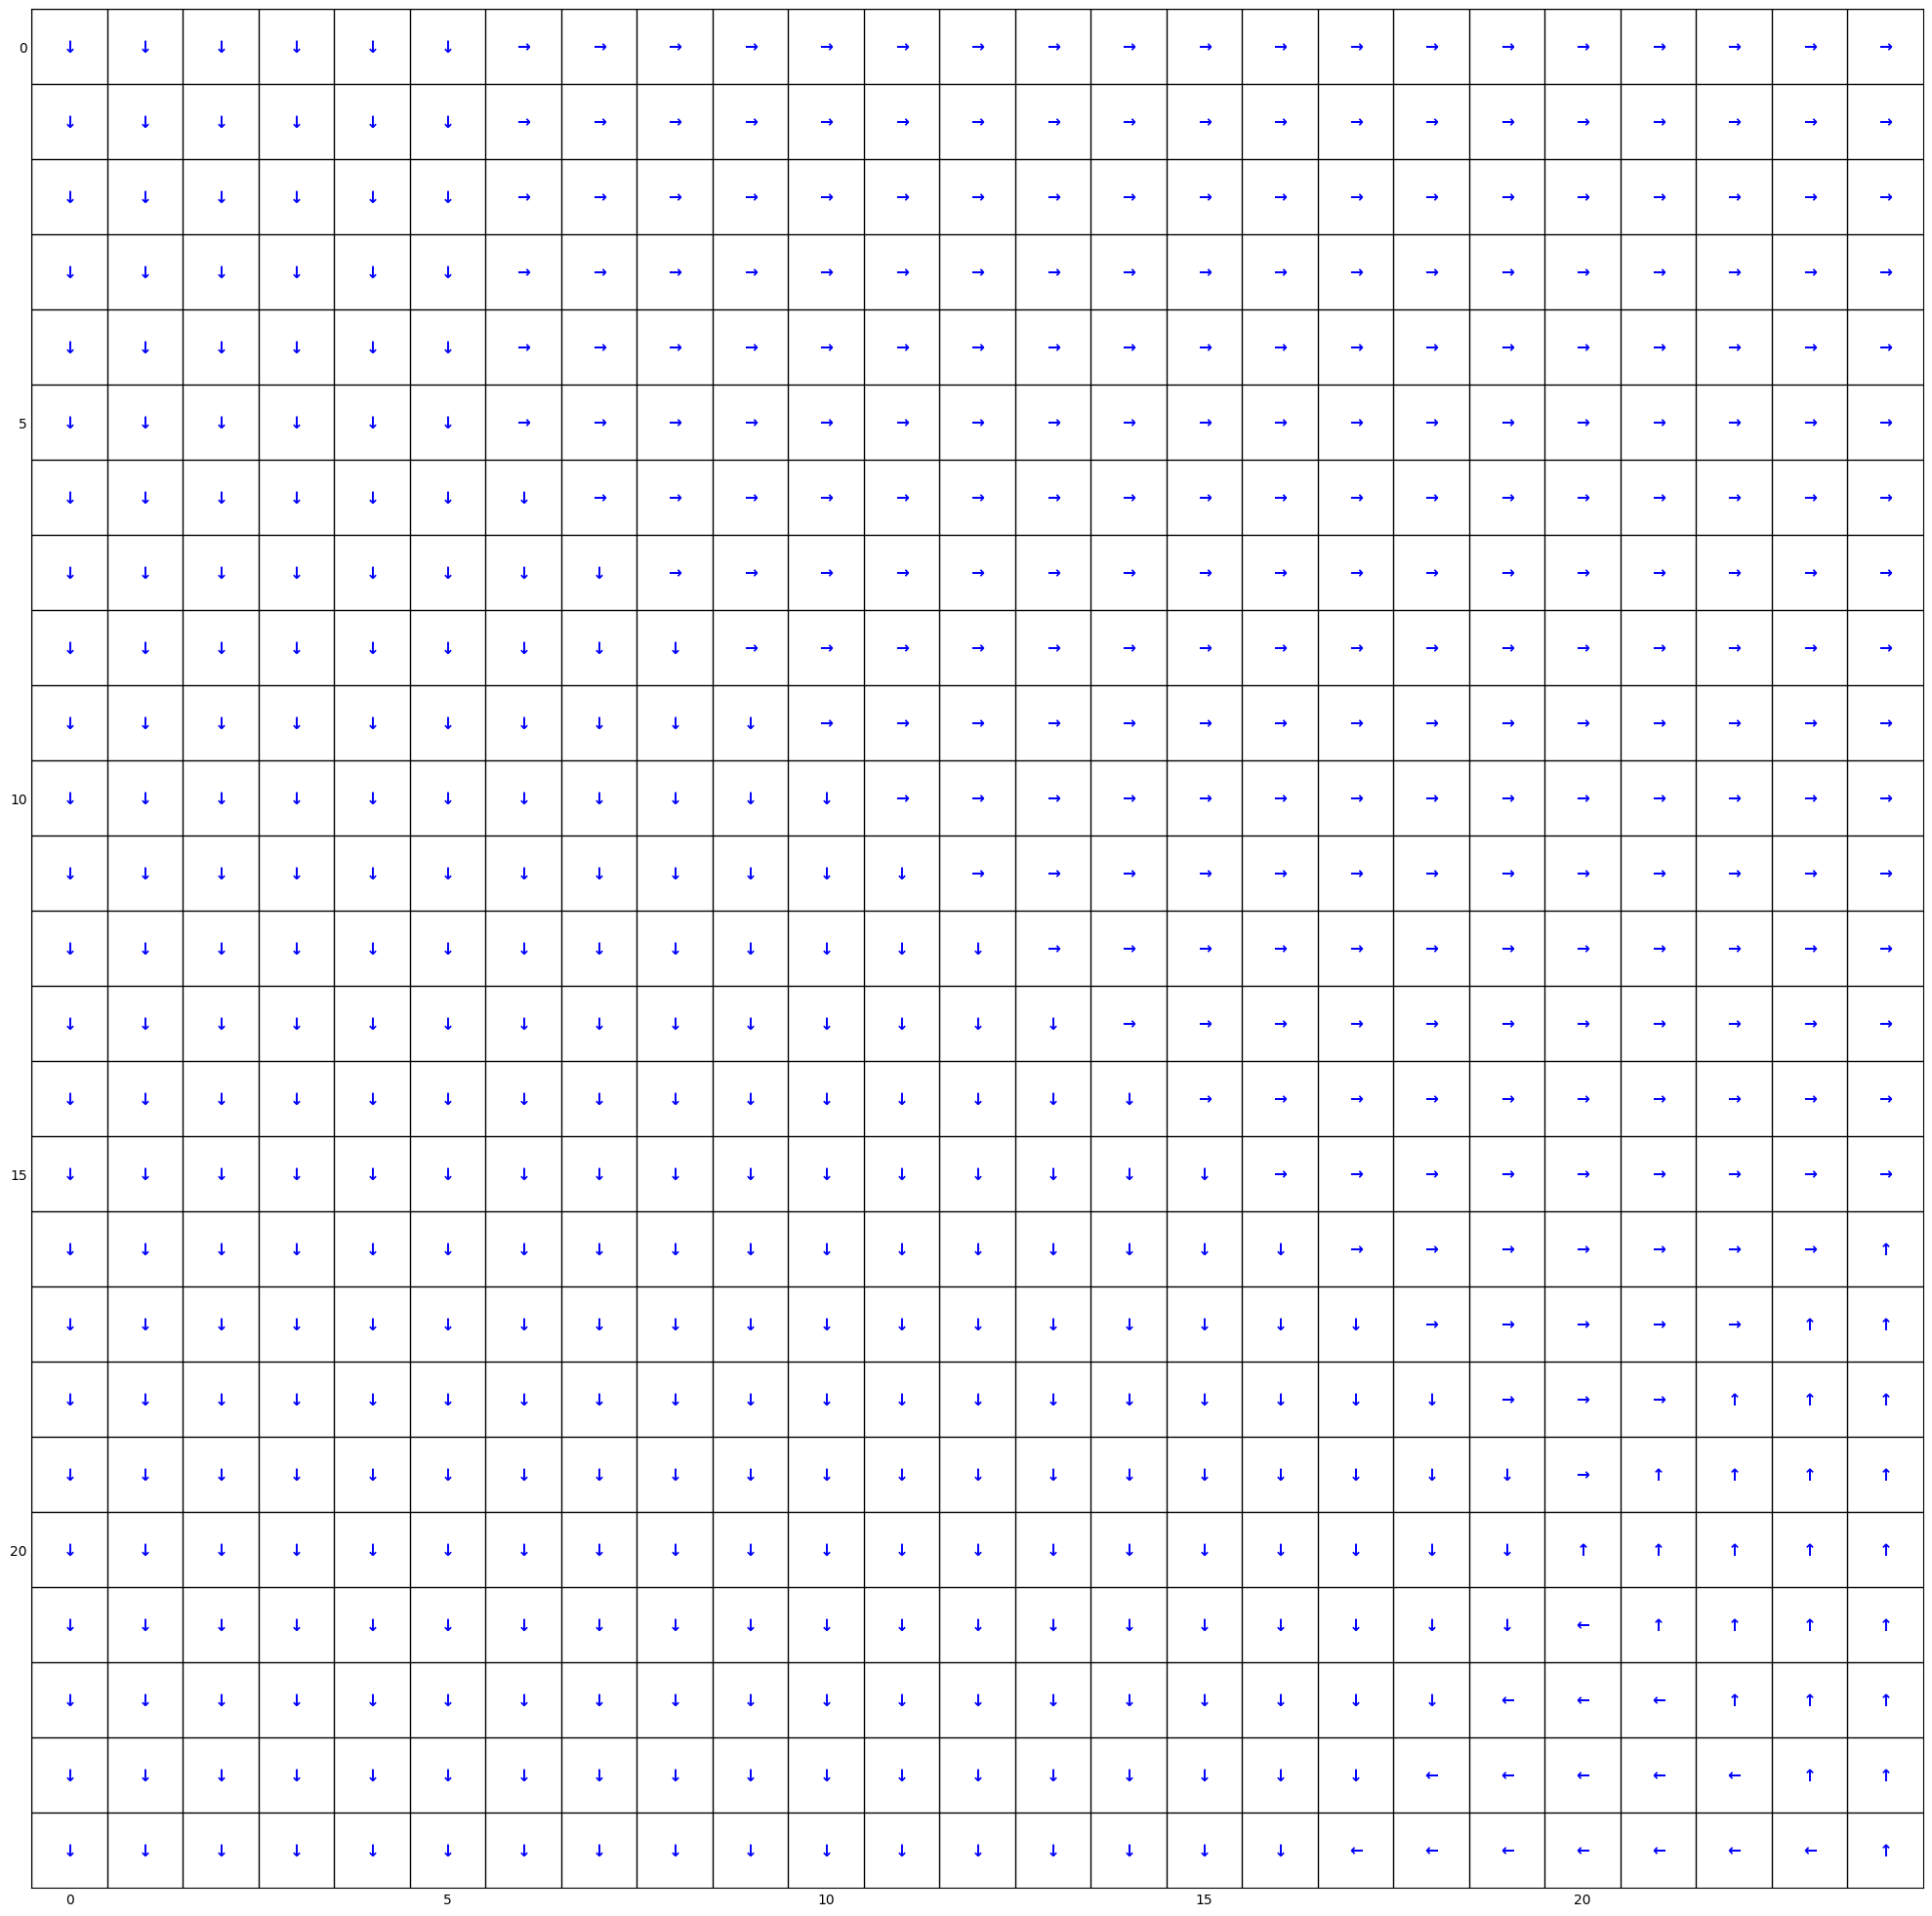

In [ ]:
# Create the environment
env = GeosearchEnv(render=False)

# Solver
solver = DPSolver(env, gamma=0.99, theta=0.0001, use_value_iteration=True)

# Solve
policy, V, Q = solver.solve()


# Policy symbols
action_symbols = {0: '↑', 1: '↓', 2: '←', 3: '→'}

# Plot the policy
plotter = PolicyPlotter_DP(grid_size=(env.grid_size, env.grid_size), 
                        policy=policy, 
                        walls=[],
                        terminal_states=[],
                        action_symbols=action_symbols)

plotter.plot()

While this environment is harder to visualize, the policy indicates to move towards the to "heat" points (gold and water) as desired. You can try rendering the environment to see the results or see the "heat" points in the grid generated by our functions.

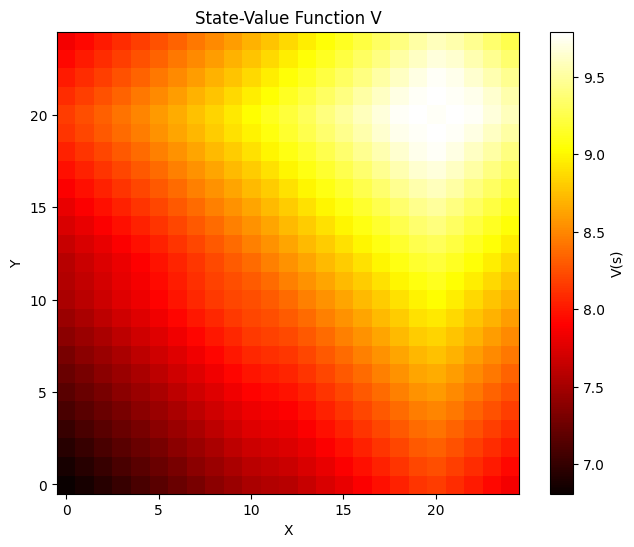

In [ ]:
# Reshape V into grid form
V_grid = V.reshape((env.grid_size, env.grid_size))

# Plot the State-Value Function as a heatmap
plt.figure(figsize=(8, 6))
plt.imshow(V_grid, cmap='hot', interpolation='nearest')
plt.colorbar(label='V(s)')
plt.title('State-Value Function V')
plt.xlabel('X')
plt.ylabel('Y')
plt.gca().invert_yaxis()
plt.show()


In [23]:
# Sample a few states to display Q(s, a)
sample_states = [(0, 0), (12, 12), (24, 24), (20, 20), (10, 10)]
print("\nAction-Value Function Q for a sample of States:")
for state in sample_states:
    s_index = env.state_to_index(state)
    print(f"State {state}:")
    for a in range(env.action_space.n):
        print(f"  Action {a}: Q = {Q[s_index, a]:.4f}")



Action-Value Function Q for a sample of States:
State (0, 0):
  Action 0: Q = 6.7410
  Action 1: Q = 6.8092
  Action 2: Q = 6.7410
  Action 3: Q = 6.8092
State (12, 12):
  Action 0: Q = 8.3799
  Action 1: Q = 8.5483
  Action 2: Q = 8.3799
  Action 3: Q = 8.5483
State (24, 24):
  Action 0: Q = 9.2650
  Action 1: Q = 9.1724
  Action 2: Q = 9.2650
  Action 3: Q = 9.1724
State (20, 20):
  Action 0: Q = 9.7641
  Action 1: Q = 9.7642
  Action 2: Q = 9.7641
  Action 3: Q = 9.7642
State (10, 10):
  Action 0: Q = 8.1483
  Action 1: Q = 8.2478
  Action 2: Q = 8.1483
  Action 3: Q = 8.2478


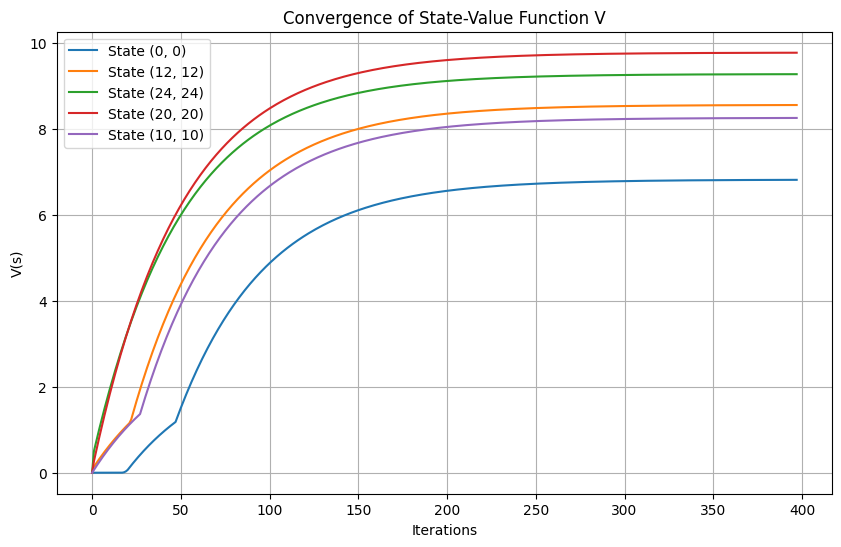

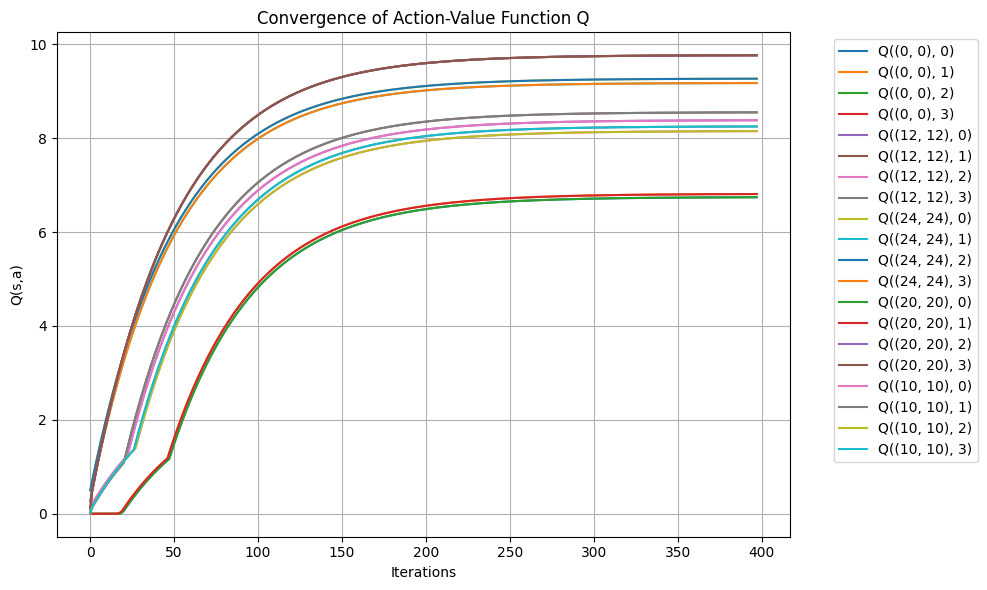

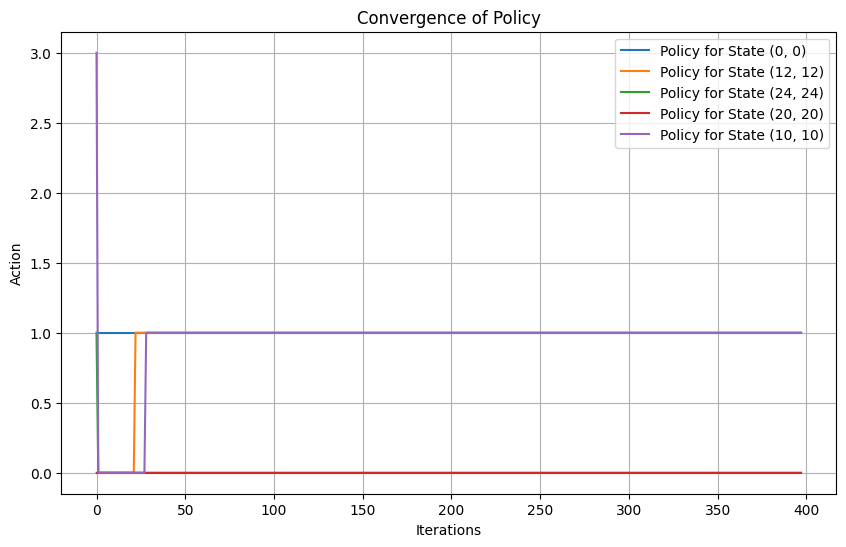

In [ ]:
# Plot convergence of V for sample states
V_history = np.array(solver.V_history)
plt.figure(figsize=(10, 6))
state_indices = [env.state_to_index(s) for s in sample_states]
for idx, s in enumerate(state_indices):
    plt.plot(V_history[:, s], label=f"State {sample_states[idx]}")
plt.xlabel('Iterations')
plt.ylabel('V(s)')
plt.title('Convergence of State-Value Function V')
plt.legend()
plt.grid(True)
plt.show()

# Plot convergence of Q for sample state-action pairs
Q_history = np.array(solver.Q_history)
plt.figure(figsize=(10, 6))
actions = [0, 1, 2, 3]
for idx, s in enumerate(state_indices):
    for a in actions:
        plt.plot(Q_history[:, s, a], label=f"Q({sample_states[idx]}, {a})")
plt.xlabel('Iterations')
plt.ylabel('Q(s,a)')
plt.title('Convergence of Action-Value Function Q')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()

# Plot convergence of policy for sample states
policy_history = np.array(solver.policy_history)
plt.figure(figsize=(10, 6))
for idx, s in enumerate(state_indices):
    plt.plot(policy_history[:, s], label=f"Policy for State {sample_states[idx]}")
plt.xlabel('Iterations')
plt.ylabel('Action')
plt.title('Convergence of Policy')
plt.legend()
plt.grid(True)
plt.show()


While the convergence seems more spread, it is still very fast. This game, even though is a larger space, has no walls or noise, which makes it easier to solve.

# Monte Carlo

In this section, we will show the results of the Monte Carlo solver for all the three games on our package. Remember you can utilize either Exploring starts or On-Policy First-Visit Monte Carlo Control. The default is Exploring starts.

## Boat Solved with MC

We will solve the boat environment using Monte Carlo with Exploring Starts.

Episode 100/500 completed.
Episode 200/500 completed.
Episode 300/500 completed.
Episode 400/500 completed.
Episode 500/500 completed.


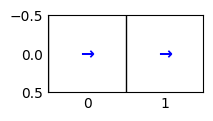

In [ ]:
# Initialize environment
env = BoatEnv(render=False)

# Solver
solver = MCSolver(env, gamma=0.99, epsilon=0.1, exploring_starts=True, episodes=500)

# Solve
policy = solver.run()

# Get the final V and Q
V = solver.V_history[-1]
Q = solver.Q_history[-1]

# Plot the optimal policy
boat_action_symbols = {0: '←', 1: '→'}
plotter = PolicyPlotter_MC_TD((1, 2), policy, action_symbols=boat_action_symbols)
plotter.plot()


500 episodes were more than enough to solve the environment. The policy is to move to the right.

In [ ]:
# Print the final V, Q, and policy

print("State-Value Function V:")
for s in range(env.observation_space.n):
    print(f"State {s}: V = {V[s]:.4f}")

print("\nAction-Value Function Q:")
for s in range(env.observation_space.n):
    print(f"State {s}:")
    for a in range(env.action_space.n):
        print(f"  Action {a}: Q = {Q[s, a]:.4f}")

print("\nOptimal Policy:")
for s in range(env.observation_space.n):
    action = policy[s]
    action_name = "West" if action == 0 else "East"
    print(f"State {s}: Take action '{action_name}'")


State-Value Function V:
State 0: V = 20.7441
State 1: V = 13.1214

Action-Value Function Q:
State 0:
  Action 0: Q = 20.6799
  Action 1: Q = 20.7441
State 1:
  Action 0: Q = 13.1125
  Action 1: Q = 13.1214

Optimal Policy:
State 0: Take action 'East'
State 1: Take action 'East'


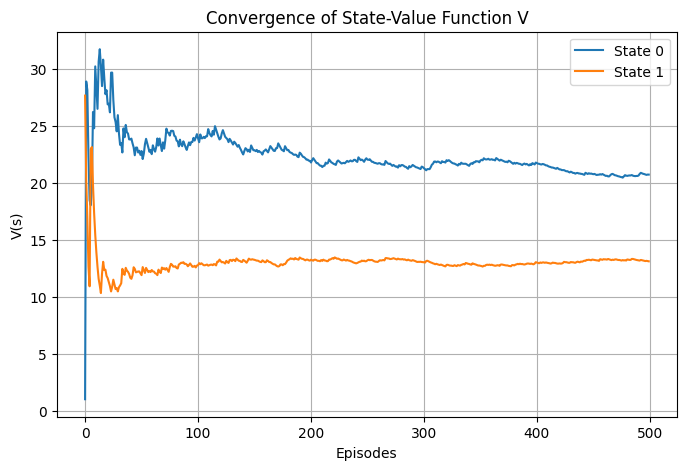

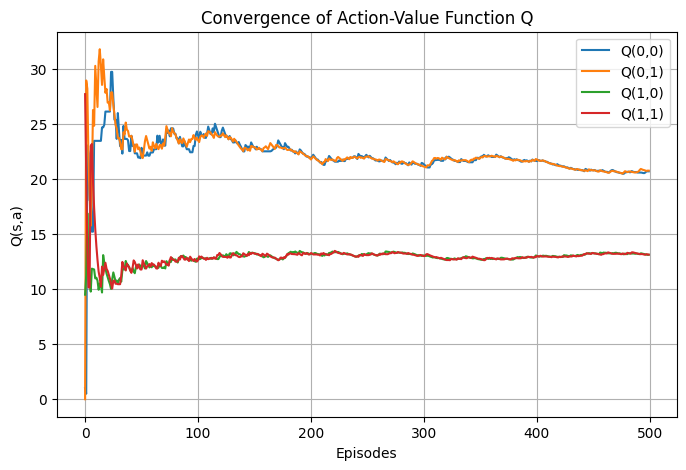

In [ ]:
# Plot convergence plots

V_history = np.array(solver.V_history)
plt.figure(figsize=(8, 5))
for s in range(env.observation_space.n):
    plt.plot(V_history[:, s], label=f"State {s}")
plt.xlabel('Episodes')
plt.ylabel('V(s)')
plt.title('Convergence of State-Value Function V')
plt.legend()
plt.grid(True)
plt.show()

Q_history = np.array(solver.Q_history)
plt.figure(figsize=(8, 5))
for s in range(env.observation_space.n):
    for a in range(env.action_space.n):
        plt.plot(Q_history[:, s, a], label=f"Q({s},{a})")
plt.xlabel('Episodes')
plt.ylabel('Q(s,a)')
plt.title('Convergence of Action-Value Function Q')
plt.legend()
plt.grid(True)
plt.show()


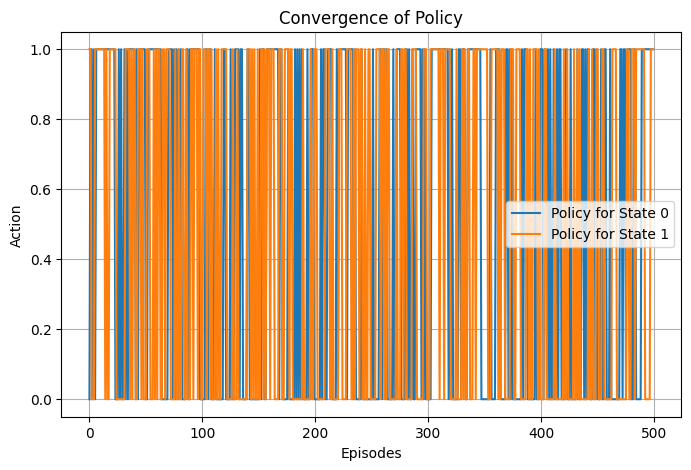

In [ ]:
# plot the policy convergence

policy_history = np.array(solver.policy_history)
plt.figure(figsize=(8, 5))
for s in range(env.observation_space.n):
    plt.plot(policy_history[:, s], label=f"Policy for State {s}")
plt.xlabel('Episodes')
plt.ylabel('Action')
plt.title('Convergence of Policy')
plt.legend()
plt.grid(True)
plt.show()


Convergence using MC is much more noisy than DP, but it still converges. It makes sense as it is a stochastic method and bases itself on the episodes.

## Gridworld Solved with MC

We will solve the gridworld environment using Monte Carlo with Exploring starts.

Episode 100/50000 completed.
Episode 200/50000 completed.
Episode 300/50000 completed.
Episode 400/50000 completed.
Episode 500/50000 completed.
Episode 600/50000 completed.
Episode 700/50000 completed.
Episode 800/50000 completed.
Episode 900/50000 completed.
Episode 1000/50000 completed.
Episode 1100/50000 completed.
Episode 1200/50000 completed.
Episode 1300/50000 completed.
Episode 1400/50000 completed.
Episode 1500/50000 completed.
Episode 1600/50000 completed.
Episode 1700/50000 completed.
Episode 1800/50000 completed.
Episode 1900/50000 completed.
Episode 2000/50000 completed.
Episode 2100/50000 completed.
Episode 2200/50000 completed.
Episode 2300/50000 completed.
Episode 2400/50000 completed.
Episode 2500/50000 completed.
Episode 2600/50000 completed.
Episode 2700/50000 completed.
Episode 2800/50000 completed.
Episode 2900/50000 completed.
Episode 3000/50000 completed.
Episode 3100/50000 completed.
Episode 3200/50000 completed.
Episode 3300/50000 completed.
Episode 3400/50000 

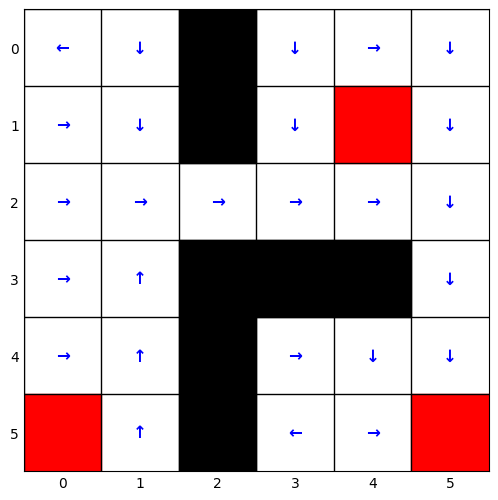

In [ ]:
# Create the environment
env = GridWorldEnv(render=False)

# Solver
solver = MCSolver(env, gamma=0.99, epsilon=0.1, exploring_starts=True, episodes=50000)

# Solve
policy = solver.run()

# Get the final V and Q
V = solver.V_history[-1]
Q = solver.Q_history[-1]

V_grid = V.reshape(env.grid_size)

terminal_coords = list(env.terminal_states.keys())

plotter = PolicyPlotter_MC_TD(env.grid_size, policy, walls=list(env.walls), terminal_states=terminal_coords)
plotter.plot()


We can see that the policy is to move to the bottom right corner, as expected. We used a large amount of episodes to solve the environment due to its noise and nature. It is interesting to see that some arrows point in a different direction than the one expected from DP. It makes sense as it is a stochastic method and bases itself on the episodes. However, they lead towards the goal.

In [ ]:
# Print the final V, Q, and policy

print("State-Value Function V:")
print(V_grid)

print("\nAction-Value Function Q for a sample of States:")
sample_states = [0, env.observation_space.n // 2, env.observation_space.n - 1]
for s in sample_states:
    state = env.index_to_state(s)
    print(f"State {state}:")
    for a in range(env.action_space.n):
        print(f"  Action {a}: Q = {Q[s, a]:.4f}")



State-Value Function V:
[[58.25803313 59.56191653 55.48853265 53.87052704 58.63128279 70.91287603]
 [60.67715075 63.03554198 63.94042008 59.30406794 69.09515794 78.03798798]
 [61.59467685 66.12038698 68.5132383  71.42912142 77.84945497 91.7456878 ]
 [57.70221524 62.53665025 65.28309907 87.99560935 92.87975146 96.87437918]
 [48.06705244 58.91421393 87.99249069 94.1455398  97.01743387 99.48128026]
 [34.17391899 46.89419121 79.09874303 94.58663899 99.87349188 99.72059563]]

Action-Value Function Q for a sample of States:
State (0, 0):
  Action 0: Q = 48.2422
  Action 1: Q = 53.7663
  Action 2: Q = 56.0690
  Action 3: Q = 58.2580
State (3, 0):
  Action 0: Q = 56.4867
  Action 1: Q = 57.7022
  Action 2: Q = 47.3510
  Action 3: Q = 52.4756
State (5, 5):
  Action 0: Q = 96.4308
  Action 1: Q = 99.3141
  Action 2: Q = 99.7206
  Action 3: Q = 95.3593


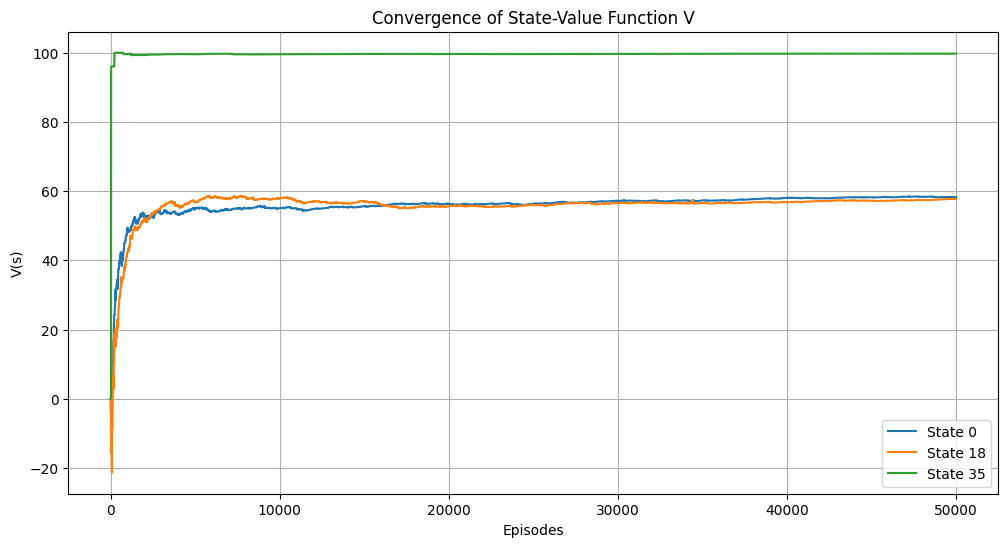

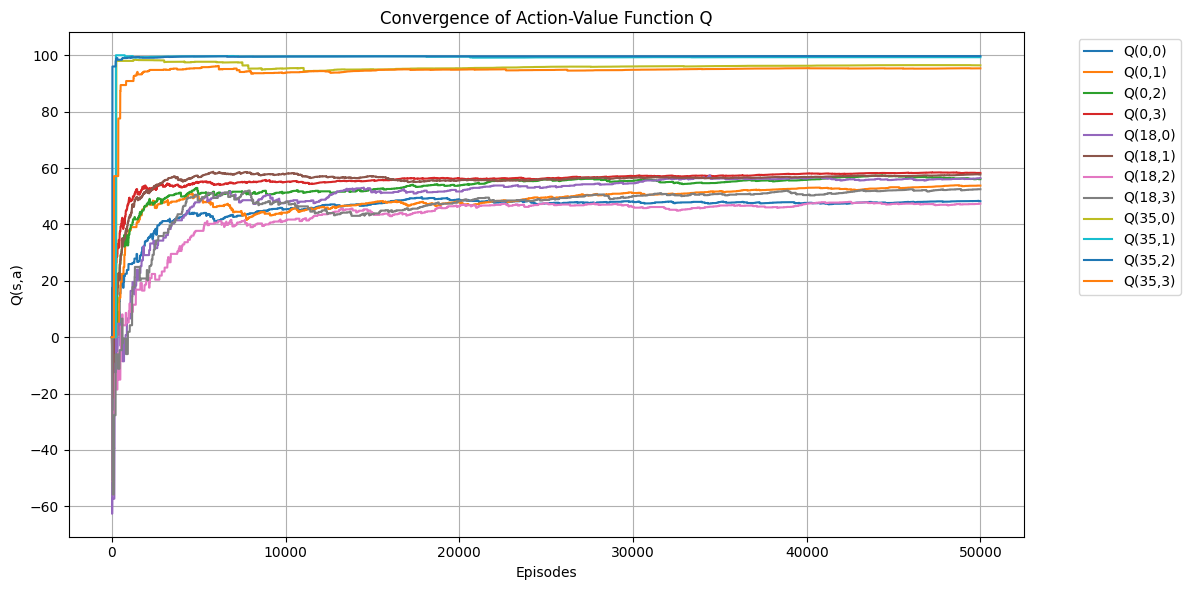

In [ ]:
# Plot convergence plots

V_history = np.array(solver.V_history)
plt.figure(figsize=(12, 6))
states_to_plot = [0, env.observation_space.n // 2, env.observation_space.n - 1]
for s in states_to_plot:
    plt.plot(V_history[:, s], label=f"State {s}")
plt.xlabel('Episodes')
plt.ylabel('V(s)')
plt.title('Convergence of State-Value Function V')
plt.legend()
plt.grid(True)
plt.show()

Q_history = np.array(solver.Q_history)
plt.figure(figsize=(12, 6))
actions = [0, 1, 2, 3]
for s in states_to_plot:
    for a in actions:
        plt.plot(Q_history[:, s, a], label=f"Q({s},{a})")
plt.xlabel('Episodes')
plt.ylabel('Q(s,a)')
plt.title('Convergence of Action-Value Function Q')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()



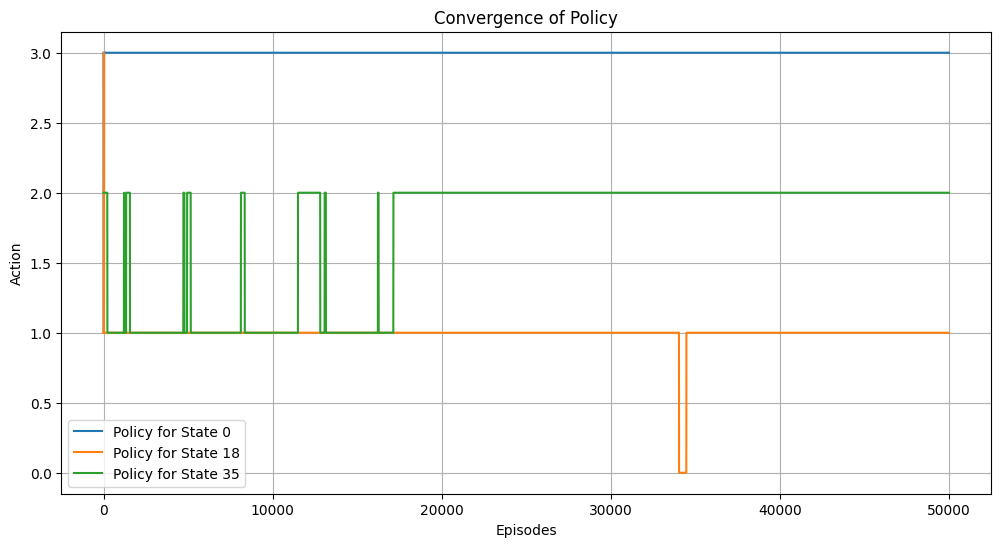

In [ ]:
# Plot convergence of policy for sample states

policy_history = np.array(solver.policy_history)
plt.figure(figsize=(12, 6))
for s in states_to_plot:
    plt.plot(policy_history[:, s], label=f"Policy for State {s}")
plt.xlabel('Episodes')
plt.ylabel('Action')
plt.title('Convergence of Policy')
plt.legend()
plt.grid(True)
plt.show()


As with the boat game, the convergence is much more noisy than DP, but it still converges. It makes sense as we are using MC. The noise in the environment also makes it harder to solve.

## Geosearch Solved with MC

We will solve the geosearch environment using Monte Carlo with On-Policy First-Visit Monte Carlo Control. We will also extend the number of maximum steps per iteration to let the agent move accordingly due to the large environment.

Episode 100/50000 completed.
Episode 200/50000 completed.
Episode 300/50000 completed.
Episode 400/50000 completed.
Episode 500/50000 completed.
Episode 600/50000 completed.
Episode 700/50000 completed.
Episode 800/50000 completed.
Episode 900/50000 completed.
Episode 1000/50000 completed.
Episode 1100/50000 completed.
Episode 1200/50000 completed.
Episode 1300/50000 completed.
Episode 1400/50000 completed.
Episode 1500/50000 completed.
Episode 1600/50000 completed.
Episode 1700/50000 completed.
Episode 1800/50000 completed.
Episode 1900/50000 completed.
Episode 2000/50000 completed.
Episode 2100/50000 completed.
Episode 2200/50000 completed.
Episode 2300/50000 completed.
Episode 2400/50000 completed.
Episode 2500/50000 completed.
Episode 2600/50000 completed.
Episode 2700/50000 completed.
Episode 2800/50000 completed.
Episode 2900/50000 completed.
Episode 3000/50000 completed.
Episode 3100/50000 completed.
Episode 3200/50000 completed.
Episode 3300/50000 completed.
Episode 3400/50000 

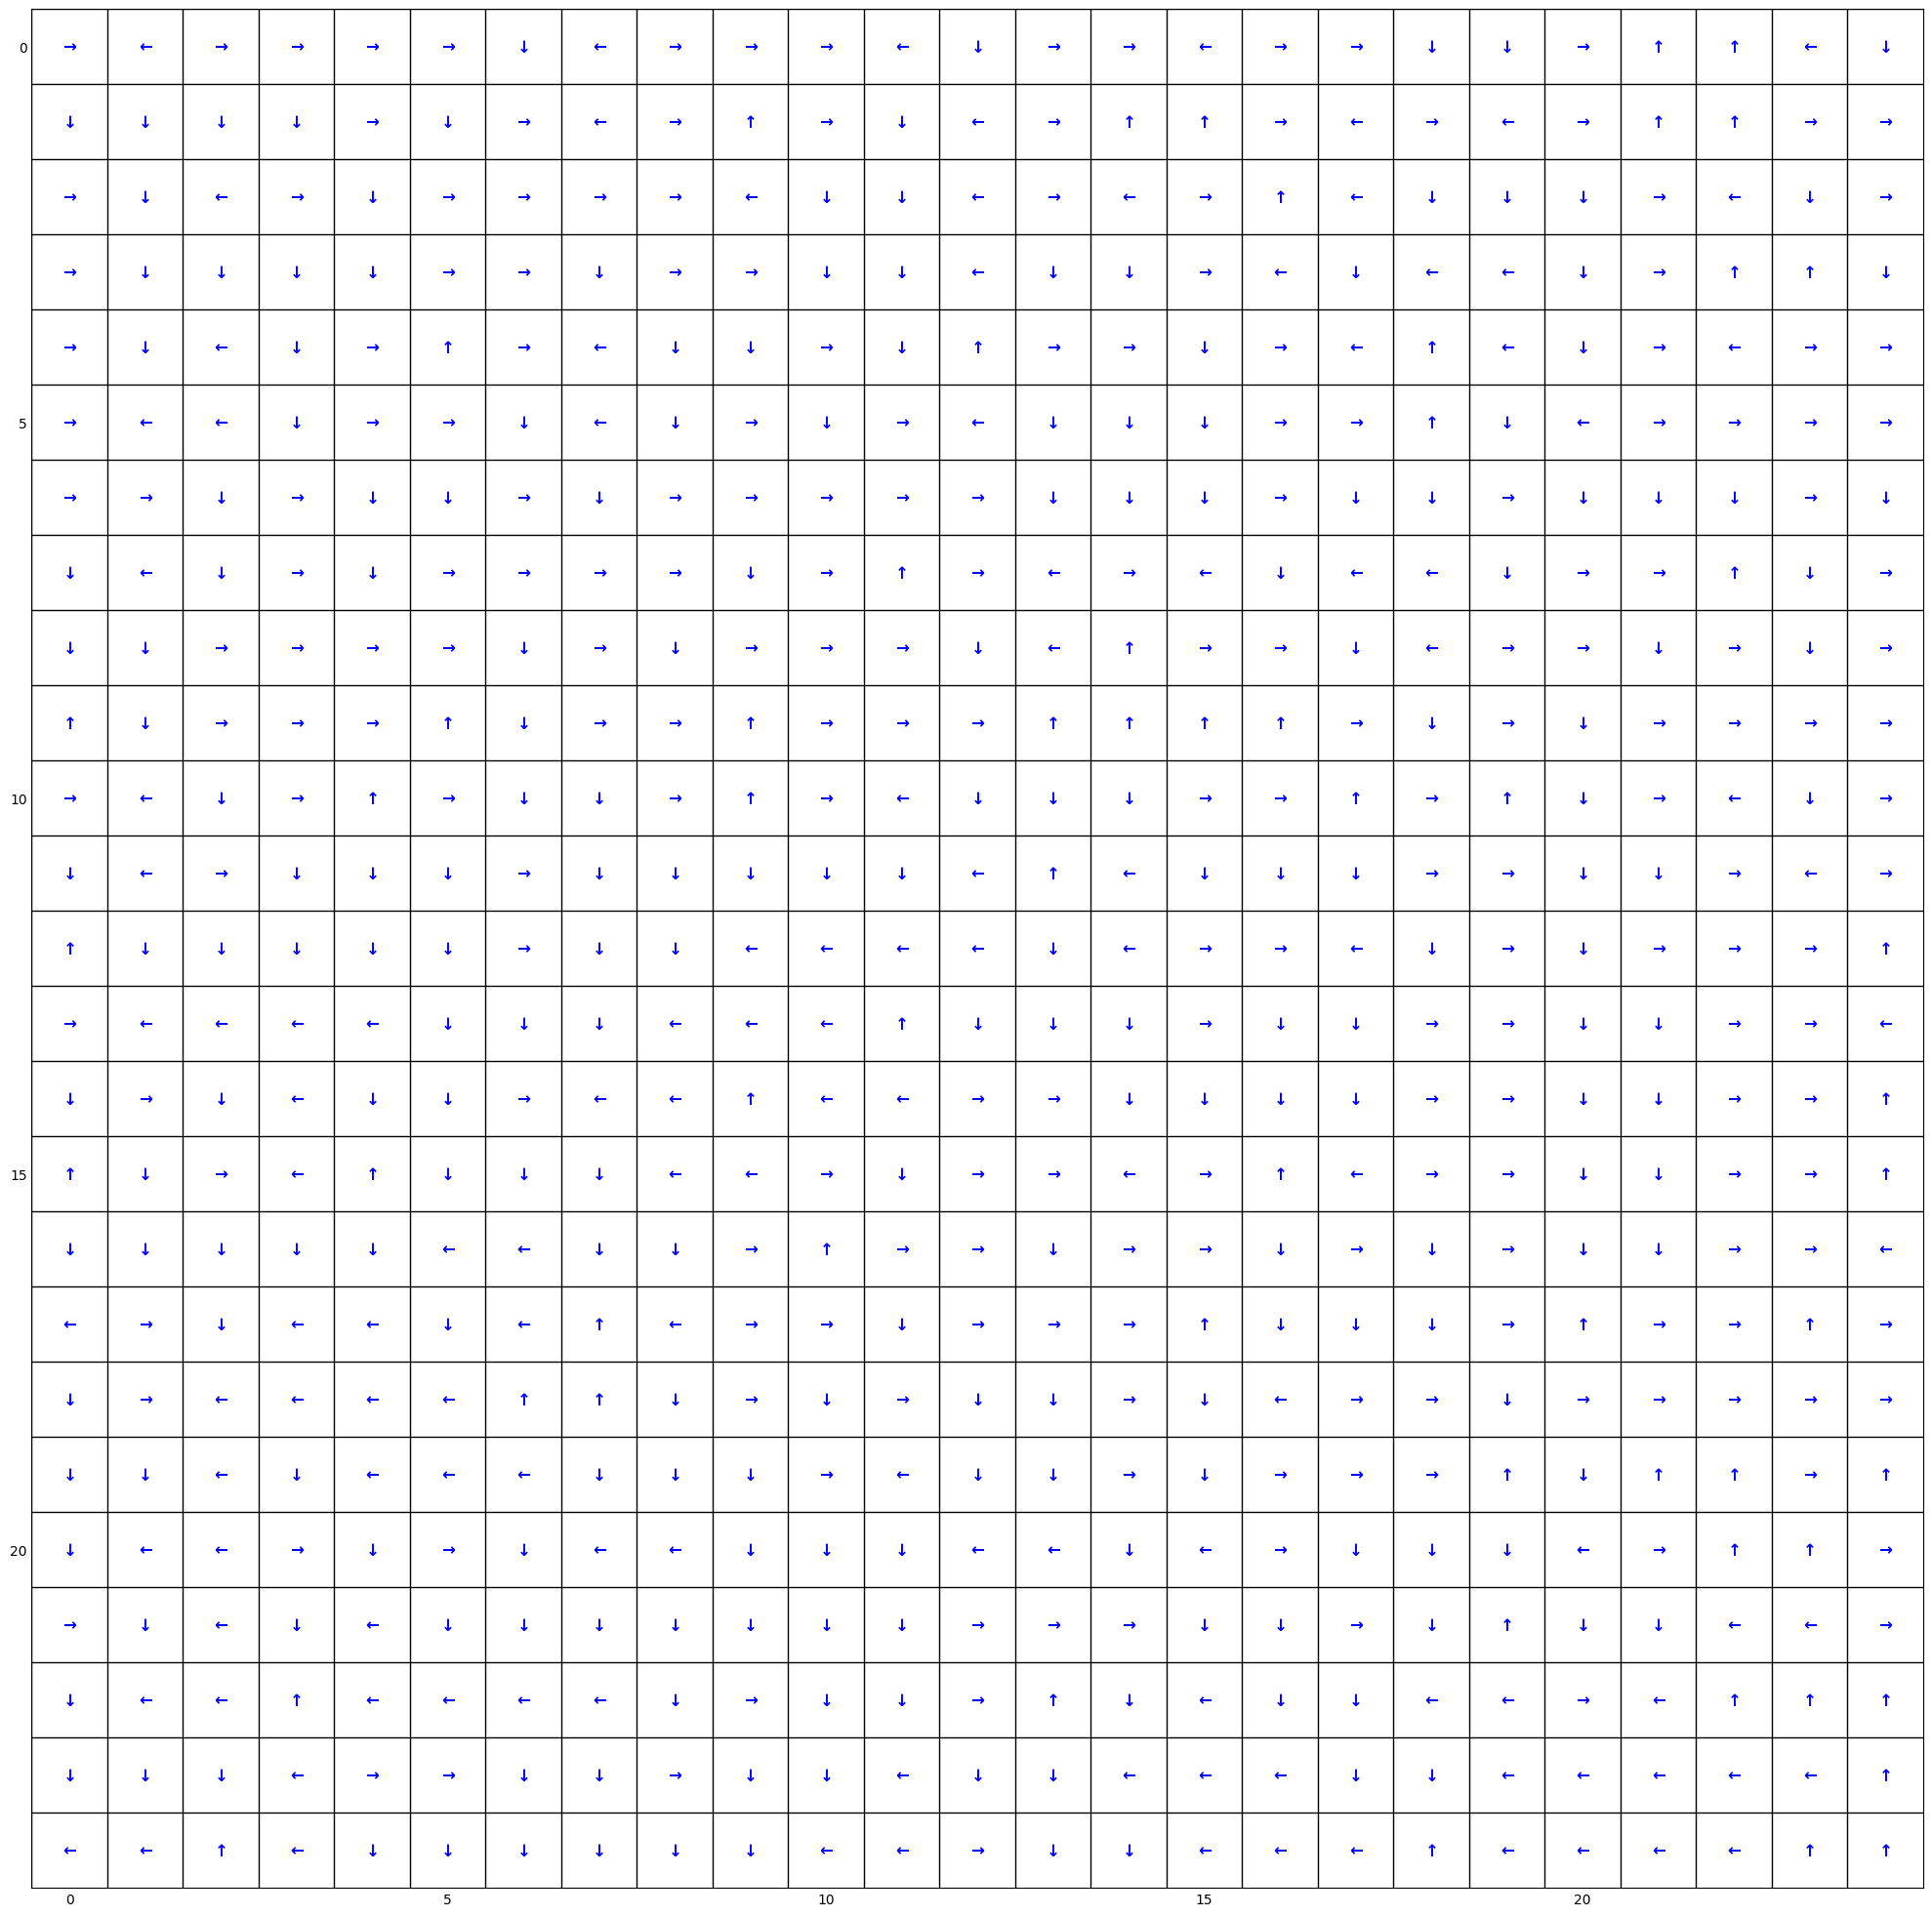

In [10]:
# Create the environment
env = GeosearchEnv(render=False)

# Solver
solver = MCSolver(env, gamma=0.99, epsilon=0.1, exploring_starts=False, episodes=50000, max_steps_per_episode=500)


# Solve
policy = solver.run()

# Get the final V and Q
V = solver.V_history[-1]
Q = solver.Q_history[-1]

V_grid = V.reshape((env.grid_size, env.grid_size))

# Plot the optimal policy
action_symbols = {0: '↑', 1: '↓', 2: '←', 3: '→'}
plotter = PolicyPlotter_MC_TD(grid_size=(env.grid_size, env.grid_size), 
                        policy=policy, 
                        walls=[],
                        terminal_states=[],
                        action_symbols=action_symbols)

plotter.plot()

As expected, the policy is to move towards the "heat" points (gold and water) as desired. However, we can see that the policy is not as clear as in the other environments and it seems much more noisy compared to tthe results of dynamic programming. This makes sense due to the nature of the environment and the inherent large space counting with the episodes of Monte Carlo. We may need more episodes to solve the environment more effectively but it is still converging.

In [11]:
# Print Action-Value Function Q for a sample of states

print("\nAction-Value Function Q for Sample States:")
sample_states = [(0, 0), (12, 12), (24, 24), (20, 20), (10, 10)]
for state in sample_states:
    s_index = env.state_to_index(state)
    print(f"State {state}:")
    for a in range(env.action_space.n):
        print(f"  Action {a}: Q = {Q[s_index, a]:.4f}")


Action-Value Function Q for Sample States:
State (0, 0):
  Action 0: Q = 1.2823
  Action 1: Q = 0.5216
  Action 2: Q = 1.0751
  Action 3: Q = 2.1665
State (12, 12):
  Action 0: Q = 1.1946
  Action 1: Q = 0.8690
  Action 2: Q = 1.4868
  Action 3: Q = 0.7418
State (24, 24):
  Action 0: Q = 4.1296
  Action 1: Q = 0.0000
  Action 2: Q = 3.9297
  Action 3: Q = 0.0000
State (20, 20):
  Action 0: Q = 2.6196
  Action 1: Q = 2.6195
  Action 2: Q = 2.6196
  Action 3: Q = 2.6194
State (10, 10):
  Action 0: Q = 0.9104
  Action 1: Q = 0.9205
  Action 2: Q = 0.9211
  Action 3: Q = 2.0670


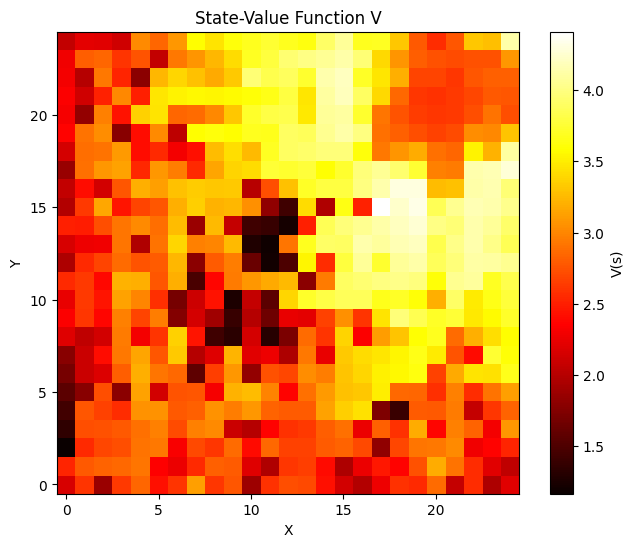

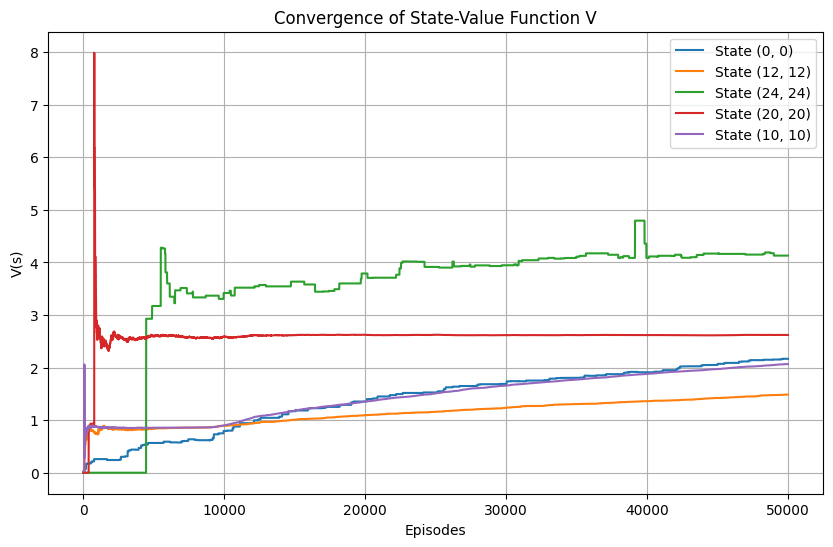

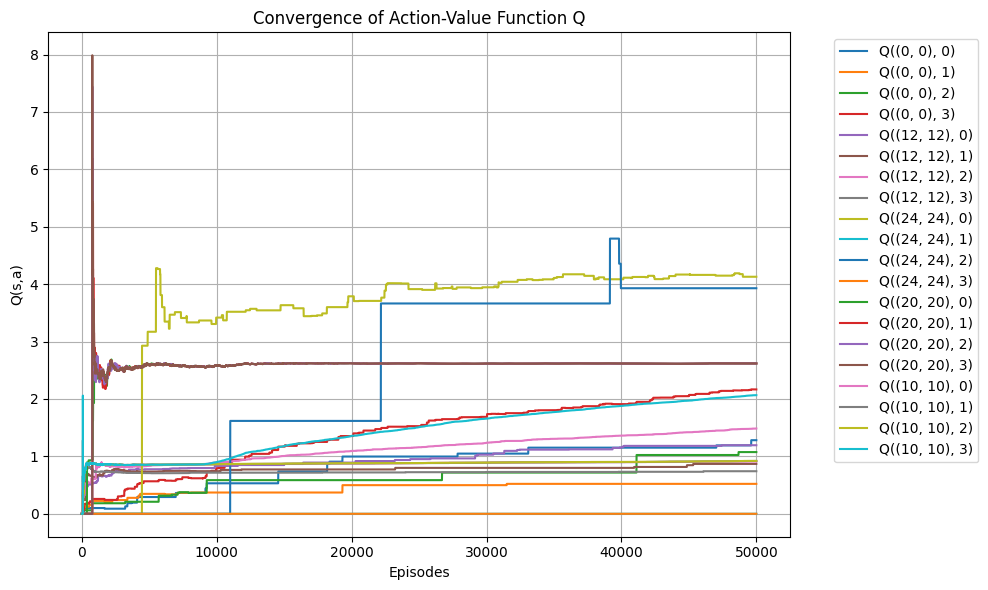

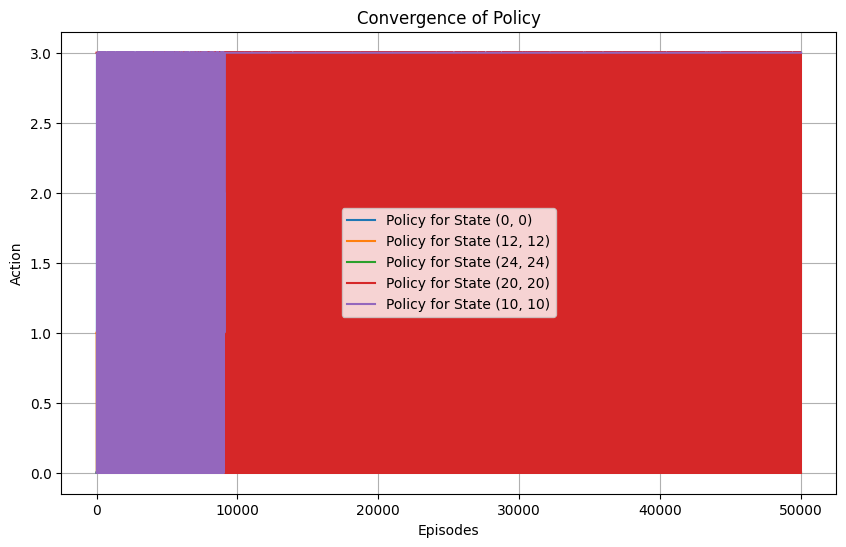

In [12]:
# Plot the State-Value Function as a heatmap

plt.figure(figsize=(8, 6))
plt.imshow(V_grid, cmap='hot', interpolation='nearest')
plt.colorbar(label='V(s)')
plt.title('State-Value Function V')
plt.xlabel('X')
plt.ylabel('Y')
plt.gca().invert_yaxis()
plt.show()

# Plot convergence plots

V_history = np.array(solver.V_history)
plt.figure(figsize=(10, 6))
state_indices = [env.state_to_index(s) for s in sample_states]
for idx, s in enumerate(state_indices):
    plt.plot(V_history[:, s], label=f"State {sample_states[idx]}")
plt.xlabel('Episodes')
plt.ylabel('V(s)')
plt.title('Convergence of State-Value Function V')
plt.legend()
plt.grid(True)
plt.show()

Q_history = np.array(solver.Q_history)
plt.figure(figsize=(10, 6))
actions = [0, 1, 2, 3]
for idx, s in enumerate(state_indices):
    for a in actions:
        plt.plot(Q_history[:, s, a], label=f"Q({sample_states[idx]}, {a})")
plt.xlabel('Episodes')
plt.ylabel('Q(s,a)')
plt.title('Convergence of Action-Value Function Q')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()

policy_history = np.array(solver.policy_history)
plt.figure(figsize=(10, 6))
for idx, s in enumerate(state_indices):
    plt.plot(policy_history[:, s], label=f"Policy for State {sample_states[idx]}")
plt.xlabel('Episodes')
plt.ylabel('Action')
plt.title('Convergence of Policy')
plt.legend()
plt.grid(True)
plt.show()


Again, as with all others, the convergence is much more noisy than DP, but it still converges. It makes sense as we are using MC.

# Temporal Difference

In this section, we will show the results of the Temporal Difference solver for all the three games on our package. Remember you can utilize either SARSA or Q-learning. The default is SARSA.

## Boat Solved with TD

We will solve the boat environment using Temporal Difference with SARSA.

Episode 100/500 completed.
Episode 200/500 completed.
Episode 300/500 completed.
Episode 400/500 completed.
Episode 500/500 completed.


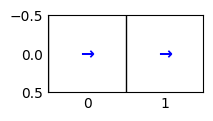

In [13]:
# Create the environment
env = BoatEnv(render=False)

# Solver
sarsa_solver = TDSolver(env, gamma=0.99, alpha=0.1, epsilon=0.1, episodes=500, method="sarsa")

# Solve
policy = sarsa_solver.run()

# Get the final V and Q for SARSA
V_sarsa = sarsa_solver.V_history[-1]
Q_sarsa = sarsa_solver.Q_history[-1]


# Plot the optimal policy
boat_action_symbols = {0: '←', 1: '→'}
plotter = PolicyPlotter_MC_TD((1, 2), policy, action_symbols=boat_action_symbols)
plotter.plot()


We can see that the policy is to move to the right, as expected. The policy is very clear and the environment is very simple. Less than 500 episodes were needed to solve the environment.

In [14]:
# Print the final V, Q, and policy

print("State-Value Function V (SARSA):")
for s in range(env.observation_space.n):
    print(f"State {s}: V = {V_sarsa[s]:.4f}")

print("\nAction-Value Function Q (SARSA):")
for s in range(env.observation_space.n):
    print(f"State {s}:")
    for a in range(env.action_space.n):
        print(f"  Action {a}: Q = {Q_sarsa[s, a]:.4f}")

print("\nOptimal Policy (SARSA):")
for s in range(env.observation_space.n):
    action = policy.get(s, 0)
    action_name = "West" if action == 0 else "East"
    print(f"State {s}: Take action '{action_name}'")


State-Value Function V (SARSA):
State 0: V = 109.3610
State 1: V = 111.0091

Action-Value Function Q (SARSA):
State 0:
  Action 0: Q = 108.5292
  Action 1: Q = 109.3610
State 1:
  Action 0: Q = 108.4314
  Action 1: Q = 111.0091

Optimal Policy (SARSA):
State 0: Take action 'East'
State 1: Take action 'East'


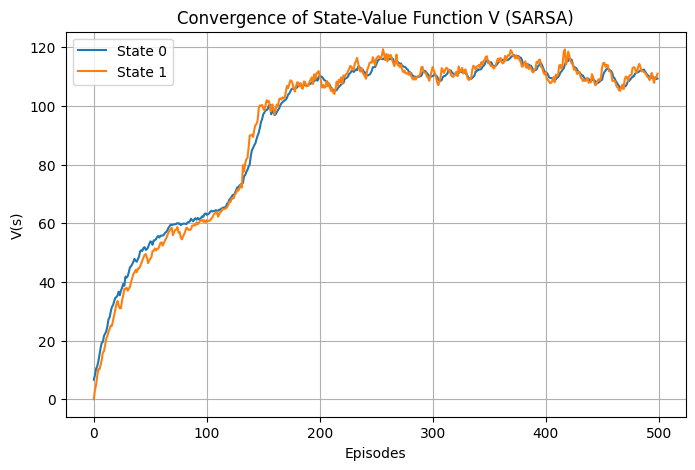

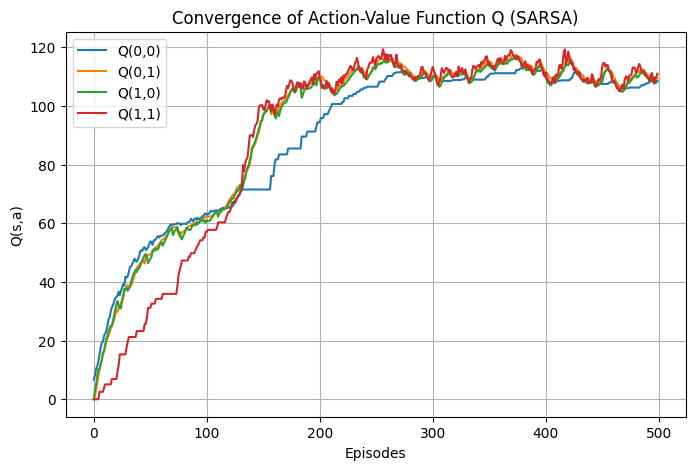

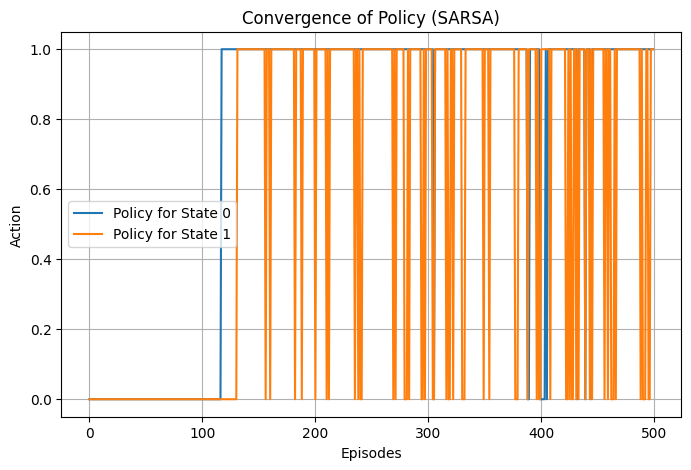

In [15]:
# Plot convergence plots

V_history_sarsa = np.array(sarsa_solver.V_history)
plt.figure(figsize=(8, 5))
for s in range(env.observation_space.n):
    plt.plot(V_history_sarsa[:, s], label=f"State {s}")
plt.xlabel('Episodes')
plt.ylabel('V(s)')
plt.title('Convergence of State-Value Function V (SARSA)')
plt.legend()
plt.grid(True)
plt.show()

Q_history_sarsa = np.array(sarsa_solver.Q_history)
plt.figure(figsize=(8, 5))
for s in range(env.observation_space.n):
    for a in range(env.action_space.n):
        plt.plot(Q_history_sarsa[:, s, a], label=f"Q({s},{a})")
plt.xlabel('Episodes')
plt.ylabel('Q(s,a)')
plt.title('Convergence of Action-Value Function Q (SARSA)')
plt.legend()
plt.grid(True)
plt.show()

policy_history_sarsa = np.array(sarsa_solver.policy_history)
plt.figure(figsize=(8, 5))
for s in range(env.observation_space.n):
    plt.plot(policy_history_sarsa[:, s], label=f"Policy for State {s}")
plt.xlabel('Episodes')
plt.ylabel('Action')
plt.title('Convergence of Policy (SARSA)')
plt.legend()
plt.grid(True)
plt.show()

While the convergence is more noisy than DP, it is less noisy than MC. This is interesting as expected due to the nature of TD.

## Gridworld Solved with TD

We will solve the gridworld environment using Temporal Difference with Q-learning.

Episode 100/50000 completed.
Episode 200/50000 completed.
Episode 300/50000 completed.
Episode 400/50000 completed.
Episode 500/50000 completed.
Episode 600/50000 completed.
Episode 700/50000 completed.
Episode 800/50000 completed.
Episode 900/50000 completed.
Episode 1000/50000 completed.
Episode 1100/50000 completed.
Episode 1200/50000 completed.
Episode 1300/50000 completed.
Episode 1400/50000 completed.
Episode 1500/50000 completed.
Episode 1600/50000 completed.
Episode 1700/50000 completed.
Episode 1800/50000 completed.
Episode 1900/50000 completed.
Episode 2000/50000 completed.
Episode 2100/50000 completed.
Episode 2200/50000 completed.
Episode 2300/50000 completed.
Episode 2400/50000 completed.
Episode 2500/50000 completed.
Episode 2600/50000 completed.
Episode 2700/50000 completed.
Episode 2800/50000 completed.
Episode 2900/50000 completed.
Episode 3000/50000 completed.
Episode 3100/50000 completed.
Episode 3200/50000 completed.
Episode 3300/50000 completed.
Episode 3400/50000 

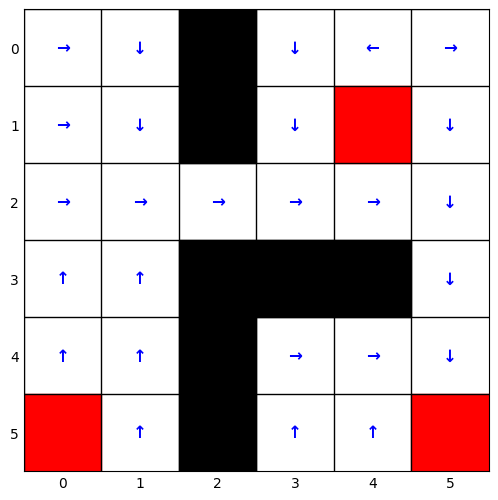

In [23]:
# Create the environment
env = GridWorldEnv(render=False)

# Solver
solver = TDSolver(env, gamma=0.99, alpha=0.1, epsilon=0.1, episodes=50000, method="q_learning")

# Solve
policy = solver.run()

# Get the final V and Q
V = solver.V_history[-1]
Q = solver.Q_history[-1]
V_grid = V.reshape(env.grid_size)

# terminal states for the plotter
terminal_coords = list(env.terminal_states.keys())

# Plot the optimal policy
plotter = PolicyPlotter_MC_TD(env.grid_size, policy, walls=list(env.walls), terminal_states=terminal_coords)
plotter.plot()

We can see that the policy is to move to the bottom right corner, as expected. We used a large amount of episodes to solve the environment due to its noise and nature. The policy is exactly the same as the one obtained with DP, which proofs the efficiency of this method in solving this environment.

In [24]:
print("State-Value Function V:")
print(V_grid)

print("\nAction-Value Function Q for a sample of States:")
sample_states = [0, env.observation_space.n // 2, env.observation_space.n - 1]
for s in sample_states:
    state = env.index_to_state(s)
    print(f"State {state}:")
    for a in range(env.action_space.n):
        print(f"  Action {a}: Q = {Q[s, a]:.4f}")

State-Value Function V:
[[64.81452738 66.96032657  0.         54.38225575 43.10283681 53.26222023]
 [66.40410697 69.14234925  0.         55.64561482  0.         71.6242858 ]
 [67.09054687 71.51320316 73.24481957 74.22207765 76.47954548 90.89601126]
 [54.98161546 63.62405729  0.          0.          0.         96.94535007]
 [43.94600015 47.01328113  0.         92.94012434 96.08132684 98.61172063]
 [ 0.         46.08805311  0.         90.93485795 93.1222424   0.        ]]

Action-Value Function Q for a sample of States:
State (0, 0):
  Action 0: Q = 56.2440
  Action 1: Q = 64.8145
  Action 2: Q = 58.7834
  Action 3: Q = 54.5829
State (3, 0):
  Action 0: Q = 54.9816
  Action 1: Q = 43.6196
  Action 2: Q = 41.6558
  Action 3: Q = 43.4601
State (5, 5):
  Action 0: Q = 0.0000
  Action 1: Q = 0.0000
  Action 2: Q = 0.0000
  Action 3: Q = 0.0000


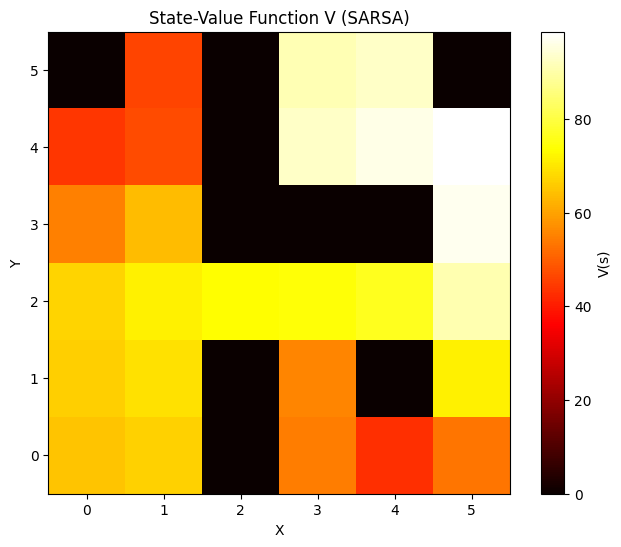

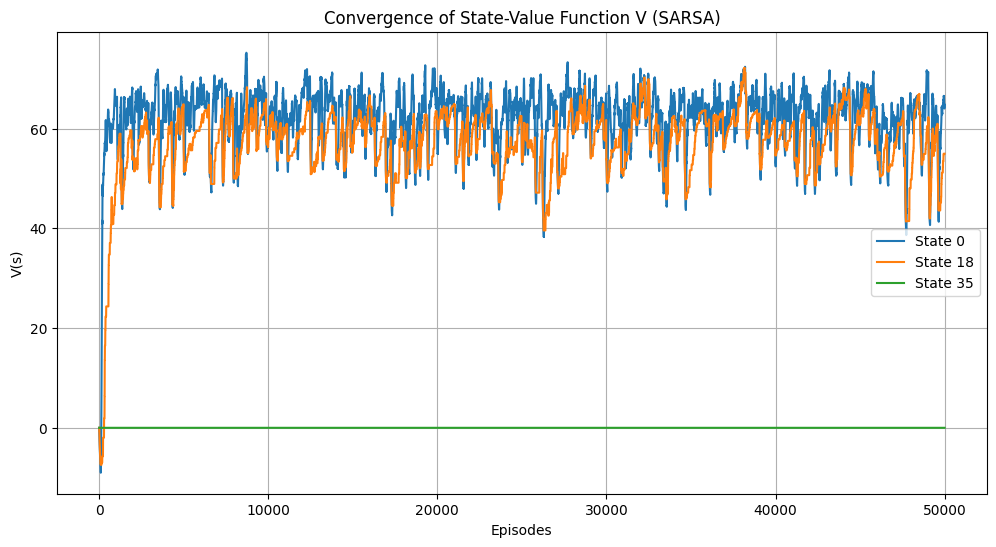

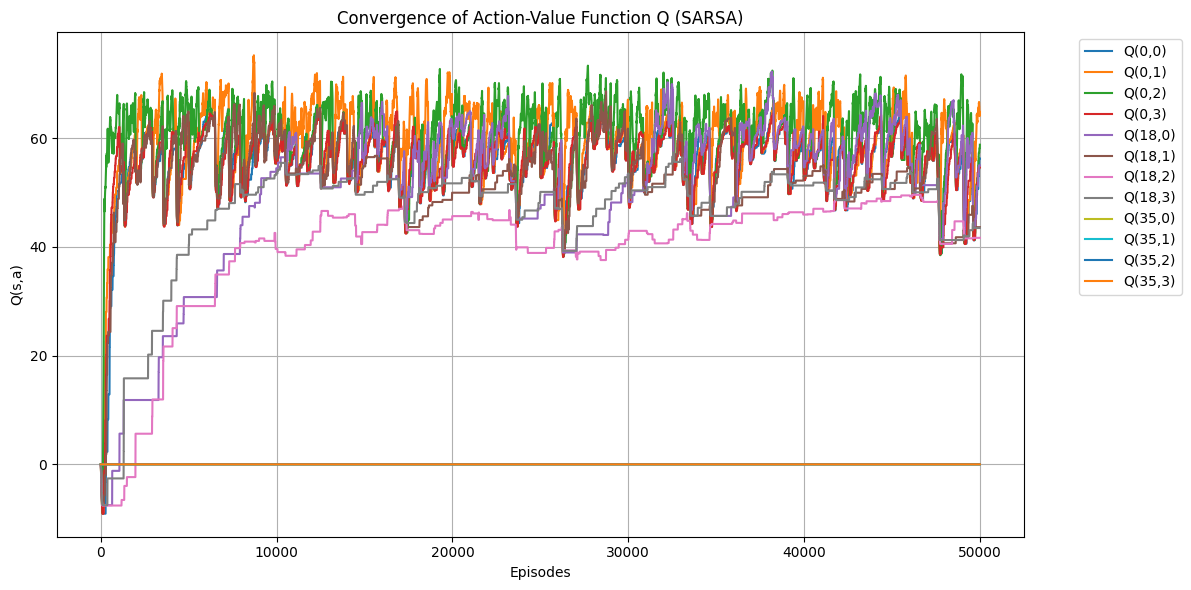

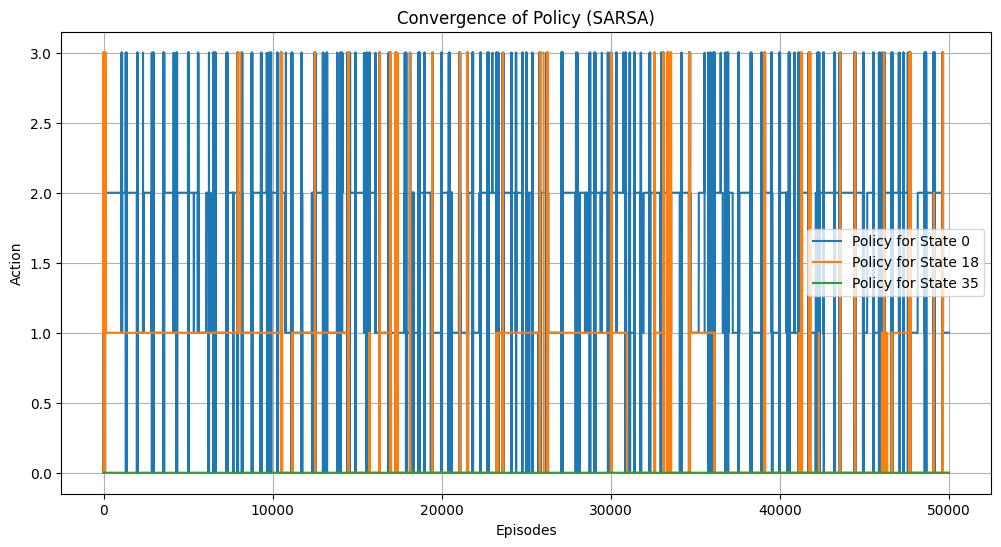

In [25]:
# Plot a heatmap of the State-Value Function V

plt.figure(figsize=(8, 6))
plt.imshow(V_grid, cmap='hot', interpolation='nearest')
plt.colorbar(label='V(s)')
plt.title('State-Value Function V (SARSA)')
plt.xlabel('X')
plt.ylabel('Y')
plt.gca().invert_yaxis()
plt.show()

# Plot convergence plots

V_history = np.array(solver.V_history)
plt.figure(figsize=(12, 6))
states_to_plot = [0, env.observation_space.n // 2, env.observation_space.n - 1]
for s in states_to_plot:
    plt.plot(V_history[:, s], label=f"State {s}")
plt.xlabel('Episodes')
plt.ylabel('V(s)')
plt.title('Convergence of State-Value Function V (SARSA)')
plt.legend()
plt.grid(True)
plt.show()

Q_history = np.array(solver.Q_history)
plt.figure(figsize=(12, 6))
actions = [0, 1, 2, 3]
for s in states_to_plot:
    for a in actions:
        plt.plot(Q_history[:, s, a], label=f"Q({s},{a})")
plt.xlabel('Episodes')
plt.ylabel('Q(s,a)')
plt.title('Convergence of Action-Value Function Q (SARSA)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()

policy_history = np.array(solver.policy_history)
plt.figure(figsize=(12, 6))
for s in states_to_plot:
    plt.plot(policy_history[:, s], label=f"Policy for State {s}")
plt.xlabel('Episodes')
plt.ylabel('Action')
plt.title('Convergence of Policy (SARSA)')
plt.legend()
plt.grid(True)
plt.show()

The convergence is more noisy than DP, but it is less noisy than MC in general, but not in the beggining of the process. 

## Geosearch Solved with TD

We will solve the geosearch environment using Temporal Difference with Q-learning.

Episode 100/50000 completed.
Episode 200/50000 completed.
Episode 300/50000 completed.
Episode 400/50000 completed.
Episode 500/50000 completed.
Episode 600/50000 completed.
Episode 700/50000 completed.
Episode 800/50000 completed.
Episode 900/50000 completed.
Episode 1000/50000 completed.
Episode 1100/50000 completed.
Episode 1200/50000 completed.
Episode 1300/50000 completed.
Episode 1400/50000 completed.
Episode 1500/50000 completed.
Episode 1600/50000 completed.
Episode 1700/50000 completed.
Episode 1800/50000 completed.
Episode 1900/50000 completed.
Episode 2000/50000 completed.
Episode 2100/50000 completed.
Episode 2200/50000 completed.
Episode 2300/50000 completed.
Episode 2400/50000 completed.
Episode 2500/50000 completed.
Episode 2600/50000 completed.
Episode 2700/50000 completed.
Episode 2800/50000 completed.
Episode 2900/50000 completed.
Episode 3000/50000 completed.
Episode 3100/50000 completed.
Episode 3200/50000 completed.
Episode 3300/50000 completed.
Episode 3400/50000 

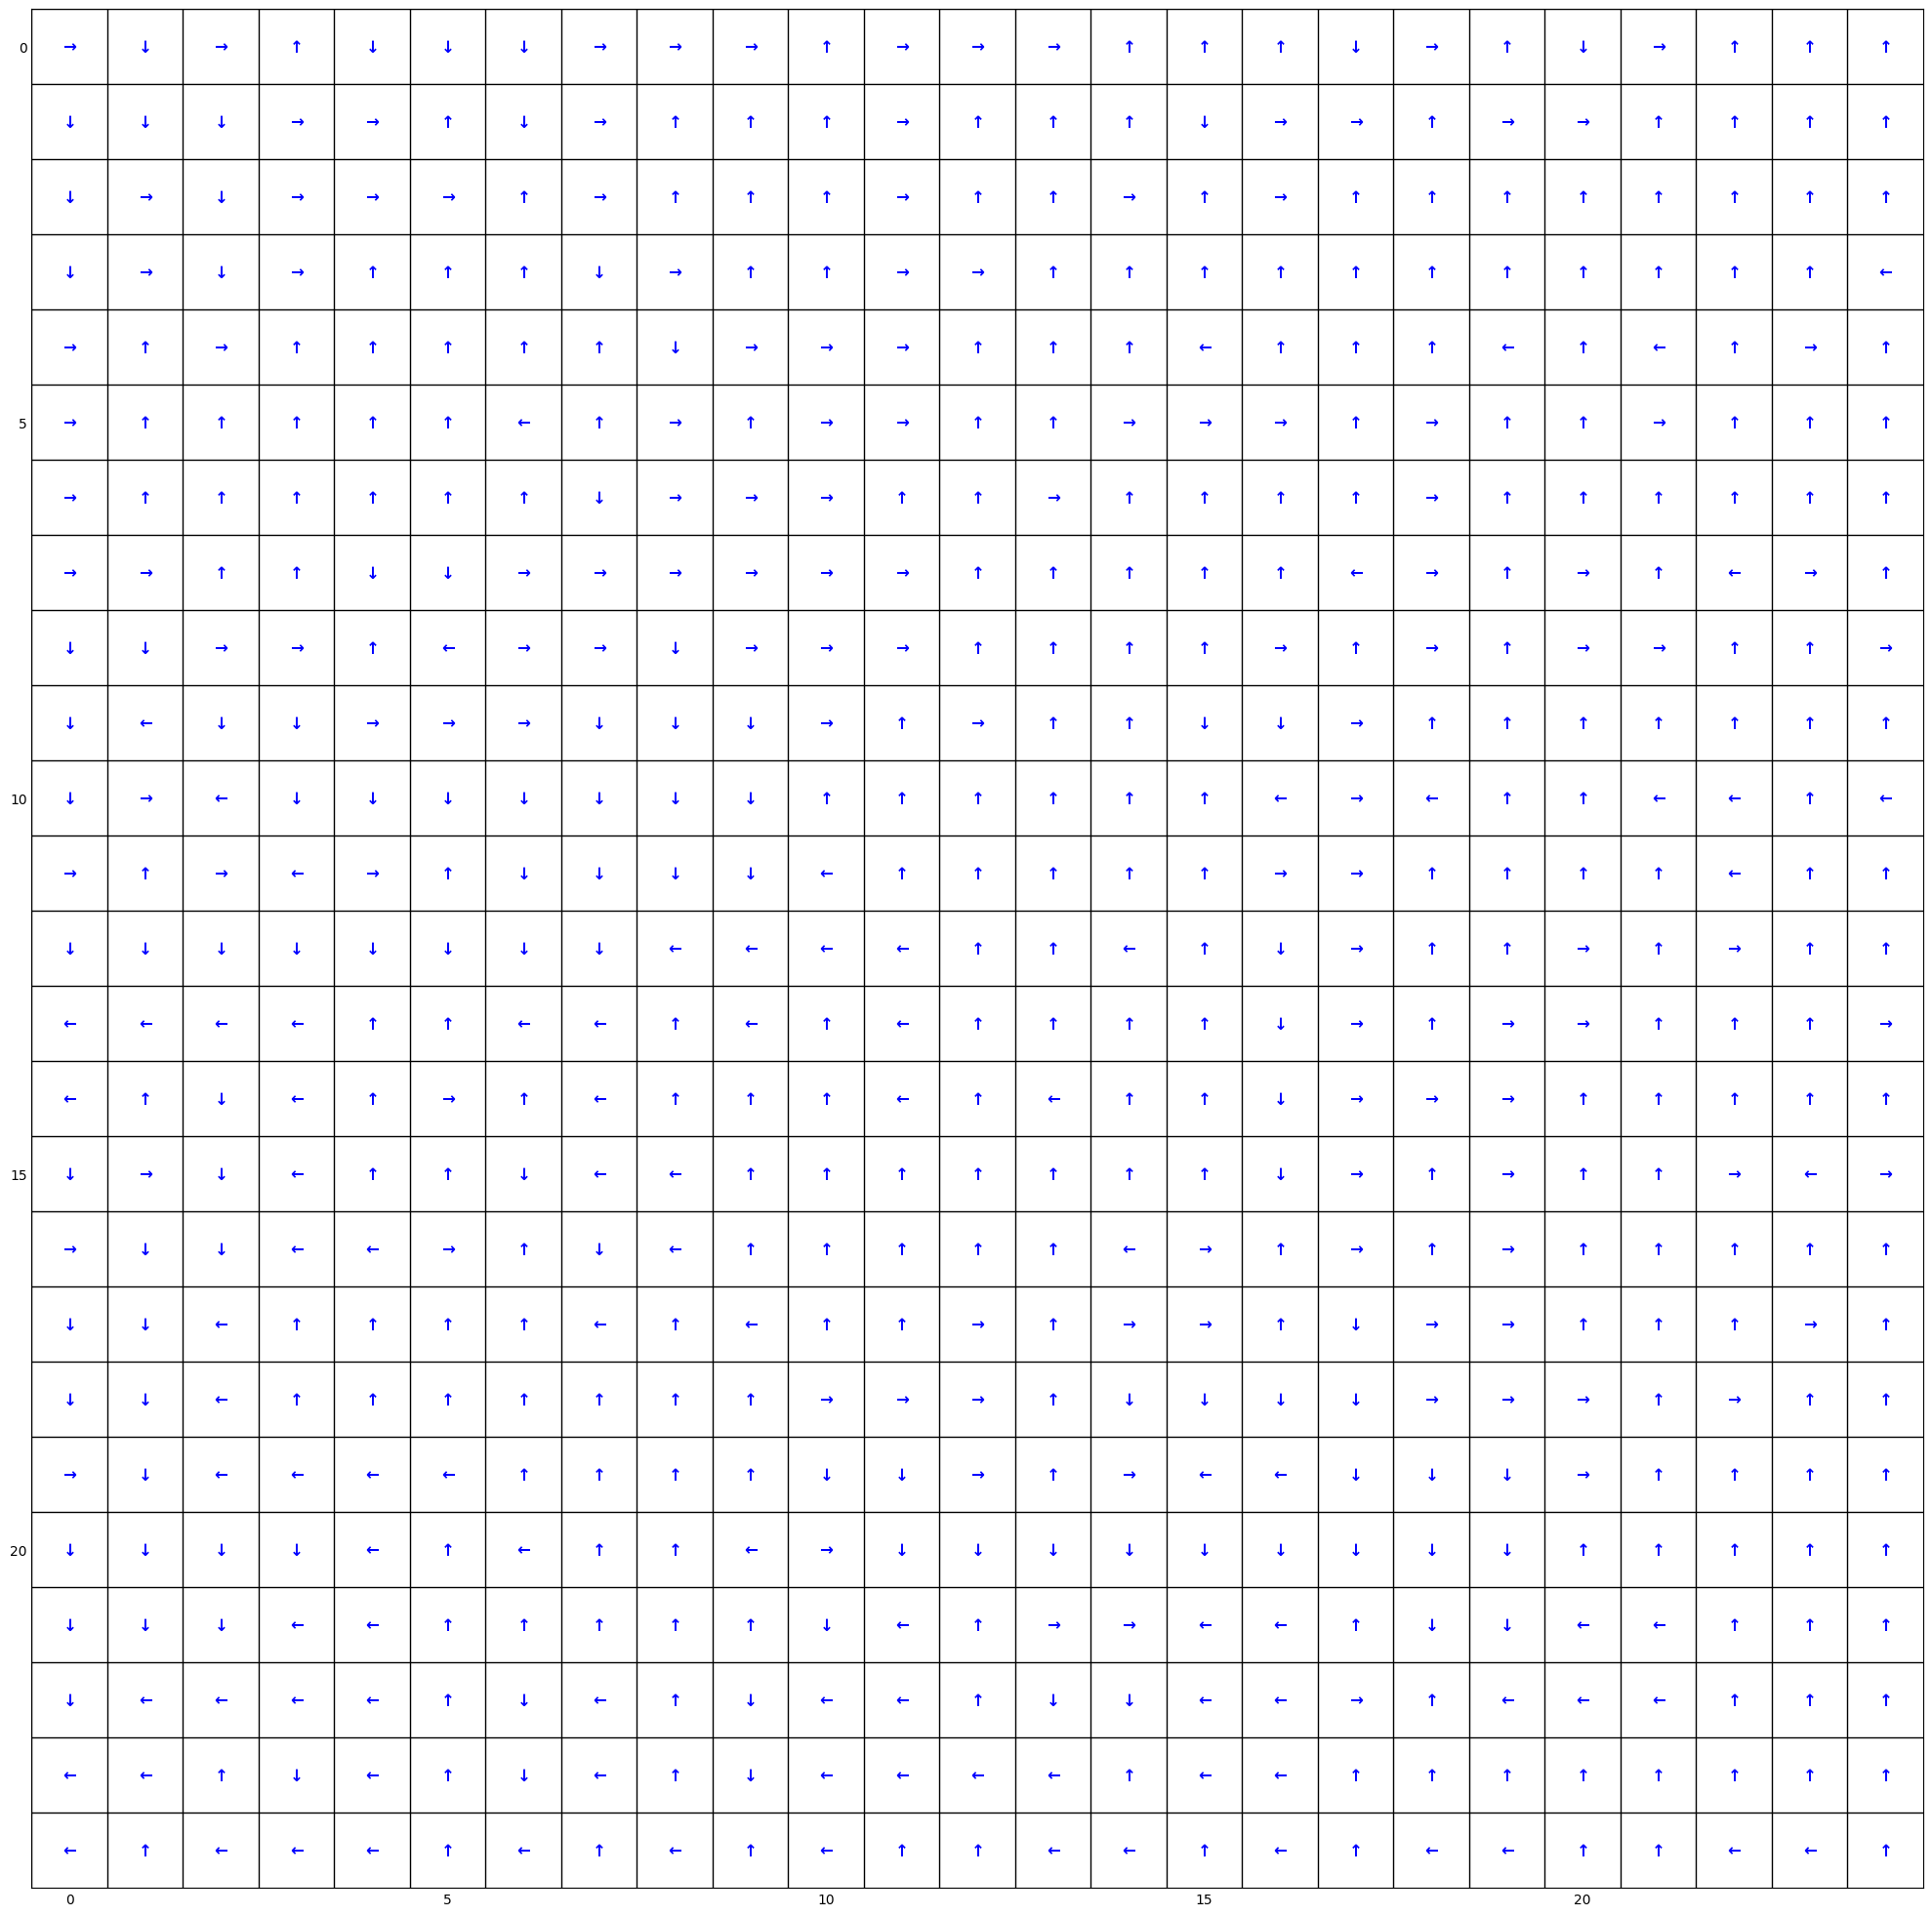

In [20]:
# Create the environment
env = GeosearchEnv(render=False)

# Solver
solver = TDSolver(env, gamma=0.99, alpha=0.1, epsilon=0.1, episodes=50000, method="q_learning", max_steps_per_episode=500)

policy = solver.run()

# Get the final V and Q
V = solver.V_history[-1]
Q = solver.Q_history[-1]
V_grid = V.reshape((env.grid_size, env.grid_size))

# Plot the optimal policy
action_symbols = {0: '↑', 1: '↓', 2: '←', 3: '→'}
plotter = PolicyPlotter_MC_TD(grid_size=(env.grid_size, env.grid_size), 
                        policy=policy, 
                        walls=[],
                        terminal_states=[],
                        action_symbols=action_symbols)

plotter.plot()

We can see that the policy is to move towards the "heat" points (gold and water) as desired. While it seems better than Monte Carlo, it is still noisy and not as clear as the results of dynamic programming. This makes sense due to the nature of the environment and the inherent large space counting with the episodes of Temporal Difference.

In [22]:
print("\nAction-Value Function Q for Sample States:")
sample_states = [(0, 0), (12, 12), (24, 24), (20, 20), (10, 10)]
for state in sample_states:
    s_index = env.state_to_index(state)
    print(f"State {state}:")
    for a in range(env.action_space.n):
        print(f"  Action {a}: Q = {Q[s_index, a]:.4f}")


Action-Value Function Q for Sample States:
State (0, 0):
  Action 0: Q = 0.6672
  Action 1: Q = 0.0515
  Action 2: Q = 1.0632
  Action 3: Q = 2.5602
State (12, 12):
  Action 0: Q = 3.1987
  Action 1: Q = 1.3074
  Action 2: Q = 1.3116
  Action 3: Q = 2.2479
State (24, 24):
  Action 0: Q = 8.2741
  Action 1: Q = 1.3916
  Action 2: Q = 0.3559
  Action 3: Q = 1.3845
State (20, 20):
  Action 0: Q = 9.7674
  Action 1: Q = 9.7674
  Action 2: Q = 9.7674
  Action 3: Q = 9.7674
State (10, 10):
  Action 0: Q = 3.2558
  Action 1: Q = 3.2558
  Action 2: Q = 3.2558
  Action 3: Q = 3.2558


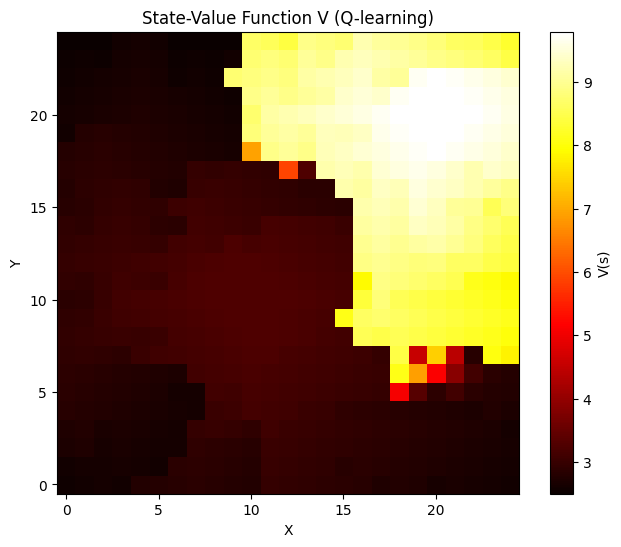

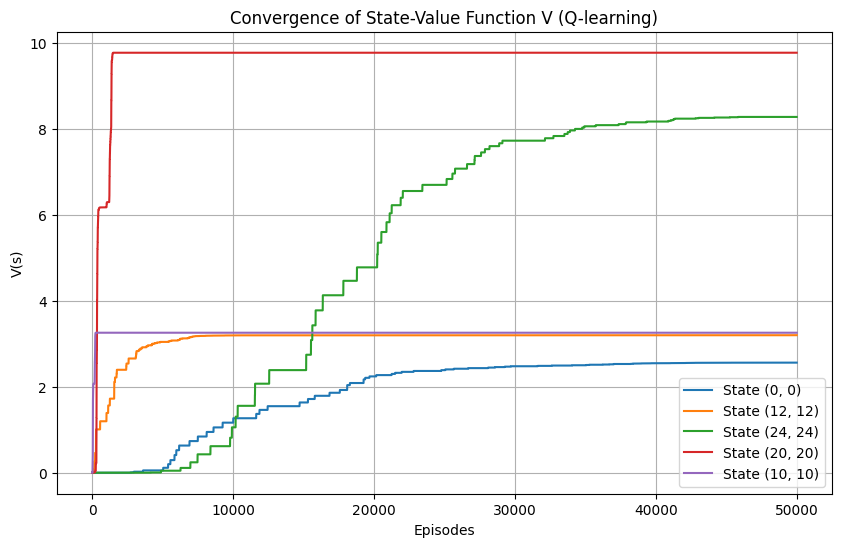

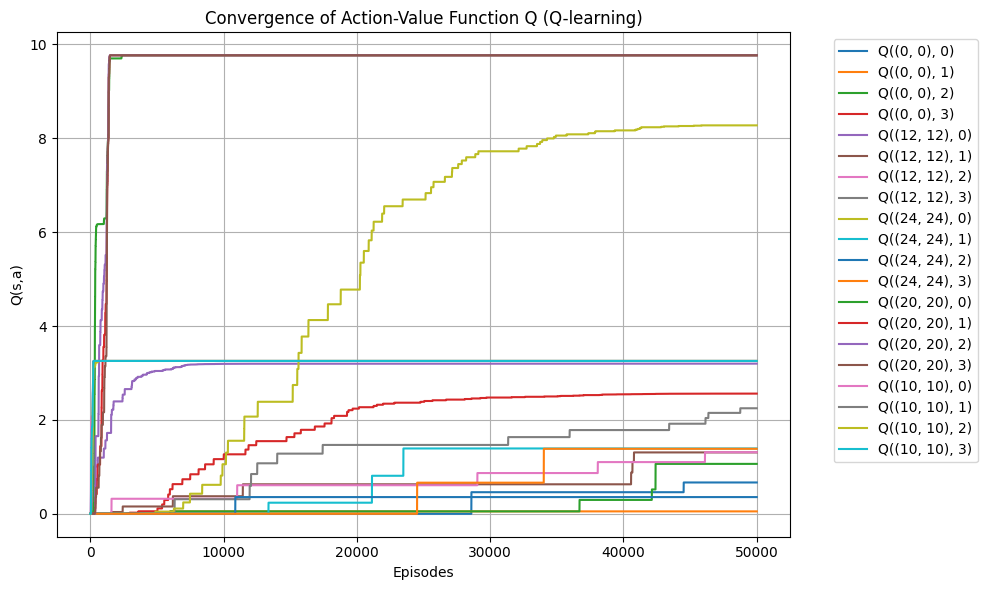

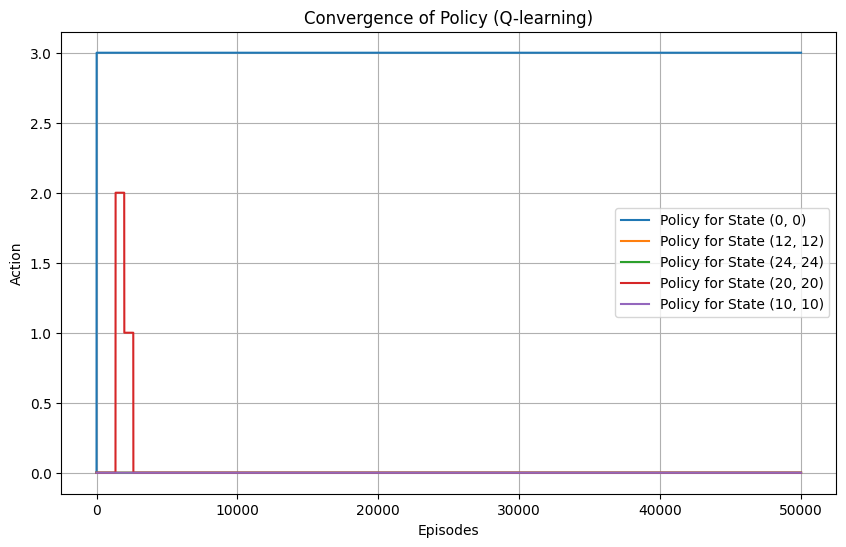

In [21]:
# Plot a heatmap of the State-Value Function V

plt.figure(figsize=(8, 6))
plt.imshow(V_grid, cmap='hot', interpolation='nearest')
plt.colorbar(label='V(s)')
plt.title('State-Value Function V (Q-learning)')
plt.xlabel('X')
plt.ylabel('Y')
plt.gca().invert_yaxis()
plt.show()

# Plot convergence plots

V_history = np.array(solver.V_history)
plt.figure(figsize=(10, 6))
sample_states = [(0, 0), (12, 12), (24, 24), (20, 20), (10, 10)]
state_indices = [env.state_to_index(s) for s in sample_states]
for idx, s in enumerate(state_indices):
    plt.plot(V_history[:, s], label=f"State {sample_states[idx]}")
plt.xlabel('Episodes')
plt.ylabel('V(s)')
plt.title('Convergence of State-Value Function V (Q-learning)')
plt.legend()
plt.grid(True)
plt.show()

Q_history = np.array(solver.Q_history)
plt.figure(figsize=(10, 6))
actions = [0, 1, 2, 3]
for idx, s in enumerate(state_indices):
    for a in actions:
        plt.plot(Q_history[:, s, a], label=f"Q({sample_states[idx]}, {a})")
plt.xlabel('Episodes')
plt.ylabel('Q(s,a)')
plt.title('Convergence of Action-Value Function Q (Q-learning)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()

policy_history = np.array(solver.policy_history)
plt.figure(figsize=(10, 6))
for idx, s in enumerate(state_indices):
    plt.plot(policy_history[:, s], label=f"Policy for State {sample_states[idx]}")
plt.xlabel('Episodes')
plt.ylabel('Action')
plt.title('Convergence of Policy (Q-learning)')
plt.legend()
plt.grid(True)
plt.show()

The convergence is more noisy than DP, but it is less noisy than MC in general. However, the results seem to be better than Monte Carlo.

# Conclusion

Due to the simplicity of our games, while DP seems to be the fastes and cleanest method on solving these "games", TD also does a good job. MC seems to be the slowest and noisiest method. It makes sense as DP is a deterministic method, while TD is a mix of deterministic and stochastic methods and MC is a stochastic method. However, if our environments were different or we needed to scale them, we would probably need to use TD or MC (and DP would be off the table).